this notebook does some spot checking on learned weight patterns in `scripts/training/yuanyuan_8k_a_3day/feature_approximation/local_pcn_recurrent/submit_sep2.py`.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.training.training_aux import load_training_results

In [3]:
from sys import path
from os.path import join, exists, dirname
from os import makedirs



In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/feature_approximation/k_bl_recurrent_k3'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_sep2 import param_iterator

In [5]:
from numpy.linalg import norm
import numpy as np

In [6]:
from sklearn.decomposition import PCA
from pickle import dump

In [7]:


def calc_raw_stats(weight_matrix):
    # weight_matrix is N * D
    # N = number of filters
    # D = size of a (flattened) filter.
    mean_all = weight_matrix.mean(axis=1)
    std_all = weight_matrix.std(axis=1)
    print('mean_all', mean_all.mean(), mean_all.std())
    print('std_all', std_all.mean(), std_all.std())
    
def calc_normed_pca(weight_matrix, verbose=False):
    # here `normed` means PCA after normalization of weight_matrix
    
    # there are multiple ways to define `normalization`
    # 
    # a simple way is to make each flattened filter with unit norm.
    weight_matrix_norm = norm(weight_matrix, axis=1, keepdims=True)
#     assert weight_matrix_norm.shape == (256,1)
    weight_matrix_normed = weight_matrix/weight_matrix_norm
    
    # tested, works as expected.
    if verbose:
        assert np.allclose(norm(weight_matrix_normed, axis=1), 1.0)
    
    
    # then let's do PCA
    pca_obj = PCA(svd_solver='full')
    pca_obj.fit(weight_matrix_normed)
    if verbose:
        # top 10 explains 60%;
        # top 20 explains 85%;
        # looks fine to me, compared to https://doi.org/10.1101/677237
        # "Recurrent networks can recycle neural resources to flexibly trade speed for accuracy in visual recognition"
        
        print(np.cumsum(pca_obj.explained_variance_ratio_)[:20])
        print(pca_obj.components_.shape)
    
    # then let's return and save them.
    return {
        'weight_matrix_norm': weight_matrix_norm,
        'weight_matrix': weight_matrix,
        'components': pca_obj.components_,
        'explained_variance_ratio': pca_obj.explained_variance_ratio_,
    }

def construct_back_by_interleave(x1, x2, by1, by2):
    n1, m1 = x1.shape
    n2, m2 = x2.shape
    assert n1 % by1 == 0
    assert n2 % by2 == 0
    assert m1==m2 and n1//by1 == n2//by2
    
    x1 = x1.reshape(n1//by1, by1, m1)
    x2 = x2.reshape(n2//by2, by2, m2)
    return np.concatenate((x1,x2), axis=1).reshape((n1+n2, m1))


def save_one_result(filename, data):
    makedirs(dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        dump(data, f)

In [8]:
# create dir
global_vars = {
    'save_dir': join(dir_dict['analyses'],
                     'yuanyuan_8k_a_3day+feature_approximation+k_bl_recurrent_k3+submit_sep2+1',
                    'pca')
}

def prepare_dir():
    save_dir = global_vars['save_dir']
    if not exists(save_dir):
        makedirs(save_dir)
prepare_dir()

In [9]:
def collect_all():
    save_dir = global_vars['save_dir']
    count = 0
    # sep_start=0 not available right now due to bad CNBC cluster GPU. but in any case, they should be very similar.
    for idx, data in enumerate(param_iterator(sep_start_range=(1,))):
        count += 1
        verbose = idx % 5 == 0

        key = data['key_this_original']
        
        def filename_gen(x):
            return join(save_dir, f'{idx}/unit_norm', f'{x}.pkl')
        
        filename_set = {'ff', 'lateral', 'all'}
        if all([exists(filename_gen(x)) for x in filename_set]):
            # right now if partially done, the partial results will be fully overwritten.
            continue
        # then load weights.
        result = load_training_results(key, return_model=False, return_checkpoint=True)
        
        loss_curves = sum([ [y['train'] for y in x] for x in result['stats_all']], [])
#         print(len(loss_curves))
        if verbose:
            # plot the curve
            plt.close('all')
            plt.figure(figsize=(10, 3))
            plt.plot(loss_curves)
            plt.show()
        
        # use float64 for all analysis to retain precision.
        weight_np = result['checkpoint']['model']['moduledict.conv0.weight'].numpy().astype(np.float64)
#         print(weight_np.dtype)
#         print(weight_np.shape)
        
        # here this num_c_lower contains both the true input, as well as layer1's last output.
        # num_c_higher is for layer2's output.
        num_c_higher, num_c_lower = weight_np.shape[0], weight_np.shape[1] - weight_np.shape[0]
        assert len(weight_np.shape)==4
        kernel_shape = weight_np.shape[2:]
        assert kernel_shape == (9,9)
        kernel_numel = kernel_shape[0]*kernel_shape[1]
        # according to the way I write the model (scripts/training/yuanyuan_8k_a_3day/feature_approximation/local_pcn_recurrent/master.py),
        # in the `32` part of (16, 32, k, k), first 16 channels are input from lower layer.
        weight_np_ff = weight_np[:,:num_c_lower]
        # rest 16 channels are input from recurrent layer.
        weight_np_lateral = weight_np[:,num_c_lower:]
#         print(weight_np_ff.shape, weight_np_lateral.shape)
        assert weight_np_ff.shape == (num_c_higher, num_c_lower) + kernel_shape
        assert weight_np_lateral.shape == (num_c_higher, num_c_higher) + kernel_shape
        
        weight_np_ff = weight_np_ff.reshape((num_c_higher*num_c_lower, kernel_shape[0]*kernel_shape[1]))
        weight_np_lateral = weight_np_lateral.reshape((num_c_higher*num_c_higher, kernel_shape[0]*kernel_shape[1]))
        
        channel_shape_all = weight_np.shape[:2]
        
        new_shape_all = (channel_shape_all[0]*channel_shape_all[1], kernel_shape[0]*kernel_shape[1])
        
        weight_np_all = weight_np.reshape(new_shape_all)
        weight_np_all_debug = construct_back_by_interleave(weight_np_ff, weight_np_lateral,by1=num_c_lower,by2=num_c_higher)
        
        
        
#         print(weight_np_all_debug.shape)
        assert np.array_equal(
            weight_np_all,
            weight_np_all_debug,
        )
#         print(weight_np_lateral.shape, weight_np_ff.shape)
        
        if verbose:
            print('idx', idx)
            print('key', key)
            # show some raw stats.
            calc_raw_stats(weight_np_ff)
            calc_raw_stats(weight_np_lateral)
            calc_raw_stats(weight_np_all)
        pca_res_dict = dict()
        pca_res_dict['ff'] = calc_normed_pca(weight_np_ff, verbose)
        pca_res_dict['lateral'] = calc_normed_pca(weight_np_lateral, verbose)
        pca_res_dict['all'] = calc_normed_pca(weight_np_all, verbose)
        
        # simply store it as pickle, for simplicity.
        
#         data_to_save = {
#             'idx': idx,
#             'key': key,
#             'ff': pca_res_ff,
#             'lateral': pca_res_lateral,
#             'all': pca_res_all,
#         }
        
        # then save.
        # I think it's good to save as `idx/unit_norm/ff|lateral|all/data.pkl`;
        # this way, I can extend as needed.
        
        for fn in filename_set:
            save_one_result(filename_gen(fn), pca_res_dict[fn])
        
    print(count)


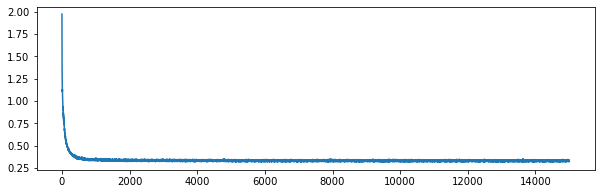

idx 0
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx38/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0005361496815771535 0.004187616421608942
std_all 0.016733814408019066 0.006735383557707461
mean_all 0.00011042364988680626 0.0021824191942599377
std_all 0.021563043057580864 0.02226535282892377
mean_all -0.00032062523775583363 0.0036566797710417985
std_all 0.018343557291206337 0.014165972761458683
[0.17781628 0.28968756 0.36823677 0.43517144 0.48790428 0.53147955
 0.5671278  0.59876534 0.62650488 0.65140444 0.67574143 0.69863917
 0.71894319 0.7388376  0.75600641 0.77249205 0.7877109  0.80153257
 0.81467532 0.82698372]
(81, 81)
[0.1906171  0.35549401 0.48322035 0.58906628 0.68383549 0.73846006
 0.7710961  0.80257454 0.82810741 0.85184451 0.8711638  0.88617054
 0.89880875 0.91034636 0.91922782 0.92780876 0.93616615 0.94306676
 0.94908856 0.95424696]
(64, 81)
[0.15624488 0.2790899  0.3849748  0.46315568 0.52243866 0.56346861
 0.60134101 0.63382258 0.66

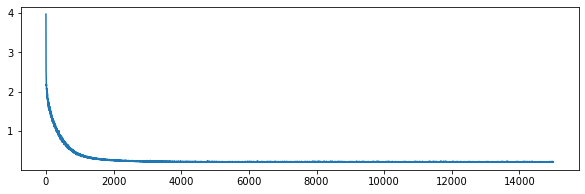

idx 5
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx38/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0002672464216890686 0.007294132715493146
std_all 0.025769261794682613 0.008700124516962233
mean_all 0.001145161624277307 0.0071612512670618045
std_all 0.03119191296620446 0.010331132205706084
mean_all 0.00020355626029972335 0.007280617987612868
std_all 0.027576812185189894 0.009621504670241037
[0.22127164 0.341505   0.43045612 0.49432597 0.5383385  0.57882288
 0.61408469 0.64794741 0.67904691 0.70686815 0.73197971 0.75395794
 0.77248578 0.7904943  0.8057678  0.82060763 0.83465344 0.84593287
 0.8562781  0.86600762]
(81, 81)
[0.22300569 0.40775563 0.57012442 0.67621822 0.75123377 0.81629131
 0.85237521 0.8716593  0.88762379 0.90281352 0.91555638 0.92726311
 0.9370902  0.94523057 0.9522614  0.95856437 0.96396554 0.96847664
 0.9725632  0.97586467]
(64, 81)
[0.21441742 0.35237422 0.46123896 0.53219126 0.58206033 0.62921024
 0.66581791 0

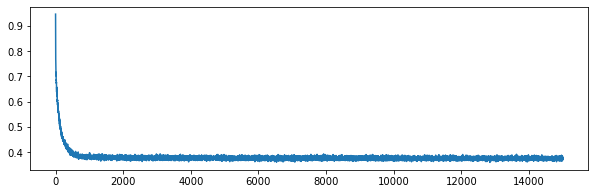

idx 10
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx39/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.000207732081395666 0.006690634229269325
std_all 0.021120574742930154 0.022974467381954564
mean_all -0.0004969052928937602 0.003065011383584525
std_all 0.024919184464355634 0.025440959755611562
mean_all -2.7147043367475924e-05 0.005751941028346877
std_all 0.022386777983405316 0.023892218817938574
[0.19678272 0.28254511 0.35580354 0.41704864 0.47003519 0.51820303
 0.55301858 0.58369784 0.61149045 0.63769191 0.66149469 0.68302154
 0.703053   0.72139318 0.73870584 0.75478933 0.76990657 0.78401445
 0.79698313 0.80913783]
(81, 81)
[0.18715203 0.33843547 0.46582621 0.56100367 0.65262796 0.72387327
 0.76476948 0.79741371 0.82706566 0.8495786  0.86882995 0.88337414
 0.89657153 0.90902819 0.91993537 0.92874405 0.93577761 0.94222766
 0.9484803  0.95400478]
(64, 81)
[0.18310302 0.28464521 0.37572662 0.4454423  0.49852945 0.5441518
 0.58689527 0.61576513 0.644132

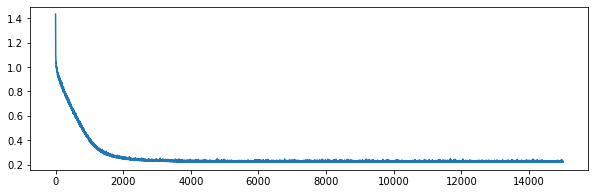

idx 15
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx39/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0011965967329700873 0.008746533968909044
std_all 0.03214230316449745 0.011845854738203725
mean_all 0.0016808111183498108 0.009246787181086097
std_all 0.036527069161376755 0.012694745035963295
mean_all -0.0002374607825301214 0.009018988057415607
std_all 0.03360389183012388 0.012310192918205195
[0.24747175 0.34370479 0.41920941 0.48245301 0.54019654 0.58836412
 0.63242844 0.66450686 0.69237086 0.71781438 0.73967919 0.75975689
 0.77594831 0.79136542 0.80668658 0.8202582  0.83301754 0.84435836
 0.85512094 0.86550131]
(81, 81)
[0.2754328  0.46606617 0.60269836 0.71425078 0.79606697 0.86243547
 0.88816008 0.90696315 0.92516084 0.93635899 0.9455422  0.95306777
 0.95902337 0.96372018 0.96835621 0.97241857 0.97564558 0.9786613
 0.98081516 0.98281785]
(64, 81)
[0.24654042 0.36865934 0.45913938 0.54039355 0.5970637  0.64666263
 0.68431452 0.7

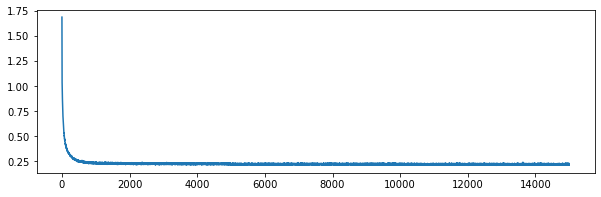

idx 20
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx102/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 2.8315472254617765e-05 0.0041684139201566195
std_all 0.01568487847216786 0.0081528004168285
mean_all 1.3241816077205755e-05 0.002504699213302124
std_all 0.0157246967500796 0.023139599398359568
mean_all 2.329092019548039e-05 0.003697973266775897
std_all 0.01569815123147177 0.014926245638546417
[0.20144305 0.31556852 0.40553057 0.46523301 0.51678269 0.55764636
 0.59161064 0.62194366 0.64526529 0.6673326  0.6882341  0.70761976
 0.72609989 0.74219016 0.75599473 0.76824252 0.78006824 0.79087201
 0.80097907 0.81095701]
(81, 81)
[0.21673146 0.35938332 0.4696255  0.55853379 0.61464363 0.65839595
 0.69421233 0.72196387 0.74642791 0.76913813 0.79023324 0.80513373
 0.81916996 0.83118737 0.8425166  0.85342614 0.86291357 0.8713991
 0.87961461 0.88696333]
(81, 81)
[0.20341792 0.3148626  0.41310309 0.47757472 0.52834745 0.569184
 0.60323556 0.63345048 0.6585253

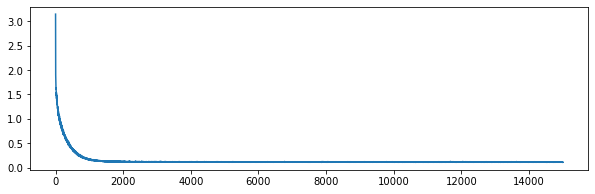

idx 25
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx103/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0002681317781479437 0.008527176799363444
std_all 0.02322375849278025 0.007735357361426639
mean_all 0.0006085305038241841 0.010106220707840535
std_all 0.030204544746135053 0.012403160819248873
mean_all 2.408898250943221e-05 0.009093469143081833
std_all 0.02555068724389852 0.010099463513850458
[0.23512542 0.33580083 0.40812812 0.47142443 0.51339416 0.55126731
 0.58566633 0.61842196 0.64532642 0.66874573 0.69072249 0.71176618
 0.7279283  0.74357839 0.75833999 0.77176116 0.78435574 0.79573175
 0.80655328 0.81628955]
(81, 81)
[0.31744778 0.5339444  0.64515236 0.73411812 0.79222389 0.83324314
 0.85789723 0.87561857 0.89183348 0.90318792 0.91425206 0.92265921
 0.92905829 0.93467948 0.93961769 0.94423706 0.94856433 0.95247064
 0.95592055 0.95915596]
(81, 81)
[0.25921442 0.39291677 0.47408022 0.54022536 0.57981847 0.61625337
 0.64950223 0.679

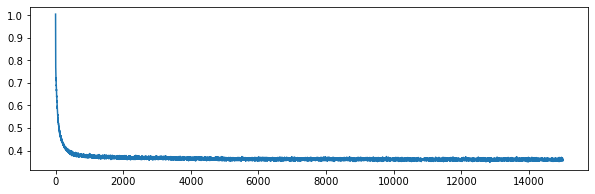

idx 30
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx103/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.00022487755460912608 0.0097088242720384
std_all 0.021207763003185064 0.01877098475322325
mean_all -0.0006882828034111116 0.005619927776475617
std_all 0.022722504430398673 0.0407862174774887
mean_all -0.00037934597087645443 0.008568338785964502
std_all 0.021712676812256266 0.028105425935573535
[0.24429329 0.3348434  0.41656299 0.4759343  0.52434697 0.55912509
 0.59259095 0.62322733 0.65233217 0.67430577 0.69612189 0.71574583
 0.73428052 0.74950207 0.76378098 0.77665492 0.78930913 0.80052195
 0.81055861 0.81998144]
(81, 81)
[0.20193958 0.36397711 0.47731481 0.56330127 0.63016013 0.67933016
 0.71296989 0.74036055 0.76493617 0.78659392 0.80344421 0.81779463
 0.83017622 0.84116447 0.85130498 0.86042385 0.86902816 0.87724739
 0.88464247 0.89184508]
(81, 81)
[0.22711701 0.3347929  0.42592738 0.48840643 0.53551337 0.57142337
 0.60586249 0.63705534 0.66

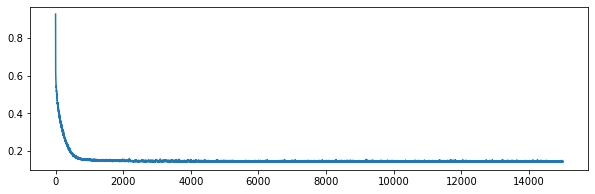

idx 35
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx166/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0001426650643246664 0.009610946100017254
std_all 0.025799956818071946 0.008496575154085246
mean_all 0.00031984980647594774 0.013409592413549314
std_all 0.03262931705363627 0.014426102161614005
mean_all 1.1506559275538292e-05 0.011025732808745399
std_all 0.028076410229926723 0.011307658807101098
[0.21196149 0.32082408 0.38618435 0.44690507 0.48596433 0.5230703
 0.55943643 0.59178174 0.61774186 0.63963319 0.6610922  0.68077827
 0.69786224 0.71354965 0.72735035 0.74064056 0.75341034 0.76550212
 0.77689058 0.78752105]
(81, 81)
[0.38685862 0.55384583 0.66551056 0.73802486 0.76897771 0.79460453
 0.81556063 0.83493091 0.85072556 0.86210942 0.87228492 0.88139381
 0.8887047  0.89499842 0.90088996 0.90644148 0.91151438 0.91633841
 0.92088152 0.92482489]
(81, 81)
[0.26683243 0.3895039  0.46718857 0.52846748 0.56451387 0.59735813
 0.62918449 0.65

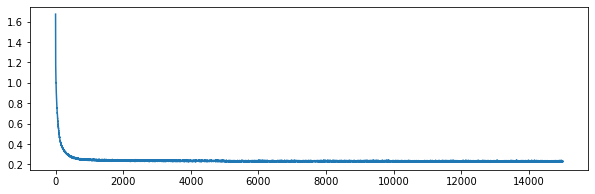

idx 40
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx167/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0005240014139555247 0.006078086733300087
std_all 0.019590232624273524 0.0076711564930166554
mean_all -6.77945611373251e-05 0.003986810725536423
std_all 0.017238592763573757 0.0271934239805797
mean_all -0.0003719324630161248 0.0054747811594415404
std_all 0.018806352670706933 0.01693972056398699
[0.22911057 0.32629672 0.40798311 0.46122787 0.50908876 0.5450262
 0.5769955  0.6070815  0.63069802 0.65184189 0.67127945 0.6884991
 0.70547987 0.7204635  0.73528932 0.74786714 0.75902266 0.76960854
 0.77997203 0.79019322]
(81, 81)
[0.27442516 0.40936471 0.49375013 0.57206364 0.61584673 0.65572739
 0.69024498 0.71835897 0.74366599 0.76122261 0.77738924 0.79133715
 0.80418211 0.81666316 0.82754692 0.83803949 0.84680476 0.85491183
 0.86267193 0.86986647]
(81, 81)
[0.23438686 0.33125874 0.42329549 0.48450209 0.53047077 0.56724878
 0.59949482 0.63009006 0.652769

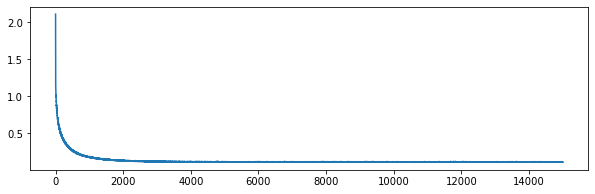

idx 45
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx167/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00033540556168106184 0.009270981907095459
std_all 0.02509500315422511 0.008201256180279072
mean_all -0.00023957255914418784 0.01150045622142279
std_all 0.03026679582839245 0.011266527865795663
mean_all -0.00030346122750210384 0.010069240735811245
std_all 0.026818934045614223 0.009648617903264618
[0.20862842 0.31907807 0.39337442 0.45906246 0.50082334 0.53669963
 0.56892926 0.59895999 0.62397515 0.64662834 0.66716668 0.68676977
 0.70502134 0.72155434 0.73584758 0.74971637 0.76217004 0.77416499
 0.78539021 0.79575029]
(81, 81)
[0.39371405 0.55843612 0.66162899 0.72890203 0.77252768 0.80378973
 0.82746947 0.84791898 0.86473224 0.87544814 0.88516127 0.89346267
 0.90054569 0.9073681  0.91296986 0.91803251 0.92272862 0.92680245
 0.93053141 0.9341403 ]
(81, 81)
[0.26601677 0.3896586  0.46853567 0.534955   0.57237447 0.60564203
 0.636738

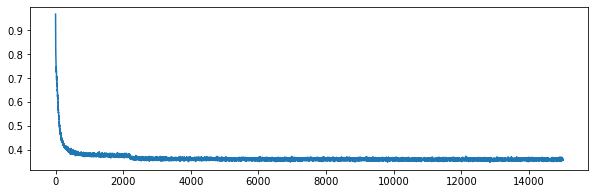

idx 50
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx230/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0016179735975584107 0.007746109955899967
std_all 0.01460586222566313 0.007255799417859488
mean_all 0.00014543027667189877 0.004393051452754218
std_all 0.020674571396082725 0.022695347013075337
mean_all -0.0010301723061483074 0.006864799150094911
std_all 0.016628765282469662 0.014662024042763797
[0.1852522  0.29162407 0.35826116 0.41481191 0.46725626 0.51266824
 0.55275836 0.58570435 0.61518905 0.63856975 0.6611787  0.68152508
 0.69909968 0.71565247 0.73146906 0.74675156 0.76146836 0.77482857
 0.78719547 0.79895347]
(81, 81)
[0.17355869 0.31630326 0.4284351  0.50598034 0.57284353 0.62633645
 0.67143209 0.70129704 0.73048264 0.75502377 0.77868506 0.7991822
 0.81727625 0.83463269 0.84906047 0.86289083 0.87552575 0.88793204
 0.89985119 0.90932901]
(64, 81)
[0.16686864 0.27015735 0.35173899 0.41281796 0.47001499 0.51799311
 0.56062067 0.5902534  0.61875

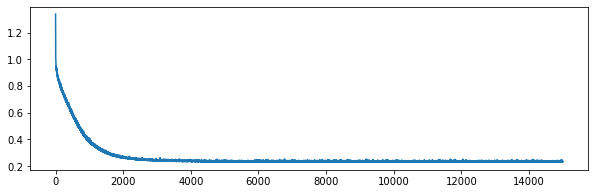

idx 55
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx230/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0007174911131470653 0.010008145052060166
std_all 0.03099947595132208 0.012682667349253073
mean_all -0.0009772966238270181 0.009429839424928685
std_all 0.036665029802268975 0.01355146667949877
mean_all -0.0008040929500403829 0.009819925417486833
std_all 0.03288799390163771 0.013250677361820304
[0.24475552 0.35137703 0.42723958 0.49013818 0.54710566 0.59983013
 0.6421481  0.66977502 0.69495983 0.7168659  0.73819186 0.75710687
 0.77479975 0.79064892 0.80623897 0.82046712 0.83399736 0.84578589
 0.85569842 0.86541337]
(81, 81)
[0.24341682 0.42857253 0.59632504 0.68937013 0.75902514 0.82300921
 0.85397759 0.87568152 0.89166189 0.90524149 0.91740226 0.92748901
 0.93696079 0.9447371  0.95061915 0.95574629 0.96042047 0.96460047
 0.96847853 0.97181367]
(64, 81)
[0.24156678 0.36153858 0.46311605 0.53085273 0.58904022 0.64111819
 0.68132634 0

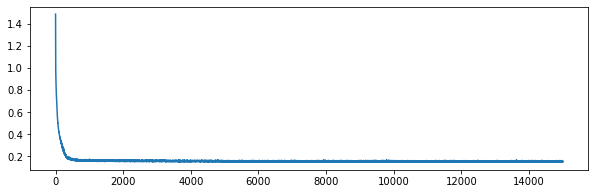

idx 60
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx231/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00025609384584919157 0.002155257925349826
std_all 0.009935144563652453 0.006075945635749356
mean_all 2.5388723249761152e-05 0.0011788215251679294
std_all 0.01224033273694276 0.014072818703026636
mean_all -0.00016226632281620733 0.0018914470000713519
std_all 0.010703540621415888 0.00958159784856607
[0.16053974 0.2702536  0.34380314 0.40766602 0.46307751 0.51080248
 0.55231464 0.5884536  0.61841361 0.64629168 0.67181336 0.6961331
 0.71754325 0.73534304 0.75275355 0.76865154 0.78321799 0.79744772
 0.81040956 0.82247881]
(81, 81)
[0.24226986 0.3974054  0.50103672 0.58250237 0.64566823 0.6922341
 0.73105045 0.76871314 0.79754961 0.82326942 0.84348126 0.85879901
 0.87263199 0.88601359 0.8966741  0.90677642 0.91606927 0.92500738
 0.93263651 0.93907938]
(64, 81)
[0.16224666 0.29373354 0.37421227 0.43749652 0.4914217  0.5398814
 0.57588197 0.61008431 0

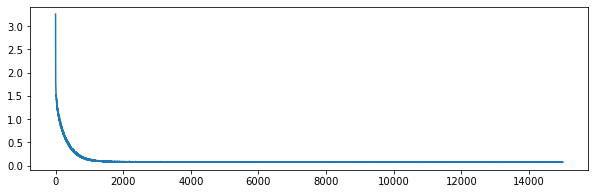

idx 65
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx294/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -2.805341091756176e-05 0.007835937260783358
std_all 0.0215892706032633 0.007765523698303329
mean_all -0.0002978461708904234 0.010638260057252985
std_all 0.028267354181068703 0.012126999699120166
mean_all -0.0001179843309085156 0.008869891543452543
std_all 0.023815298462531765 0.009956606491867899
[0.21912263 0.32667972 0.4024035  0.46196402 0.50449863 0.54627978
 0.58243405 0.61025505 0.63492083 0.65926381 0.68155468 0.70262734
 0.7216094  0.73734815 0.75250389 0.76676346 0.77939138 0.7918262
 0.80273797 0.81330358]
(81, 81)
[0.38062286 0.56776613 0.66567153 0.74736859 0.79002862 0.81987685
 0.8429241  0.86245948 0.87892046 0.89065259 0.90169508 0.90903415
 0.91589069 0.92178072 0.92758963 0.93263531 0.93717146 0.94150149
 0.94554864 0.94921349]
(81, 81)
[0.27134548 0.39983608 0.47487981 0.54235079 0.58106218 0.61683014
 0.65068335 0.67

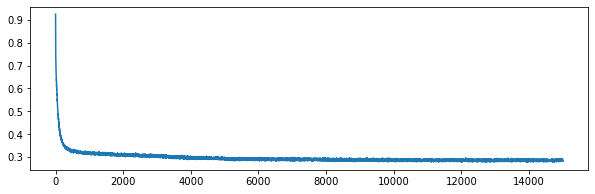

idx 70
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx294/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 1.7906724266656158e-05 0.013872647397904248
std_all 0.0334120727751226 0.036422371304703646
mean_all -0.0031661238371849783 0.014893921481641122
std_all 0.04108787576093922 0.05575054885211627
mean_all -0.001043436796217222 0.0143002131588459
std_all 0.035970673770394805 0.04397188721045016
[0.23185832 0.33761177 0.43406453 0.48647269 0.5330144  0.57300507
 0.60280167 0.63058252 0.65478839 0.67746292 0.69687215 0.7158023
 0.73308144 0.74769669 0.76201612 0.77561142 0.7869815  0.79771455
 0.80744197 0.81689572]
(81, 81)
[0.23805811 0.39870628 0.50891787 0.5826496  0.64258623 0.67552792
 0.70450136 0.73172502 0.75583955 0.7768023  0.79666711 0.81302197
 0.82807109 0.83900773 0.84842559 0.85688697 0.86498647 0.87266946
 0.87989876 0.88695382]
(81, 81)
[0.23157437 0.3490232  0.44799905 0.5054915  0.55290814 0.59108731
 0.62162814 0.64973259 0.6733088 

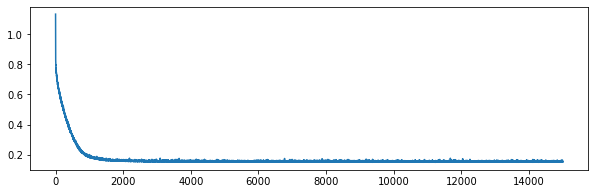

idx 75
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx295/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.000452834026029601 0.009085885592037553
std_all 0.02757056371596997 0.009530362676446875
mean_all 0.00038498026687602854 0.011595899689008928
std_all 0.034260085664773225 0.013662791707317639
mean_all -0.0001735625950610578 0.010000657957915899
std_all 0.02980040436557106 0.011520425898701999
[0.19278221 0.2923259  0.36527851 0.42775738 0.47974688 0.52171876
 0.55983381 0.59542538 0.62131964 0.64540752 0.66773856 0.68901655
 0.70831754 0.72523623 0.74072612 0.75377947 0.76634344 0.77800461
 0.78905861 0.79959252]
(81, 81)
[0.30473977 0.5002541  0.60307118 0.70209254 0.76453784 0.80515172
 0.83481033 0.85837837 0.87662823 0.8922938  0.90496582 0.91239867
 0.91919537 0.92586825 0.93184342 0.93690523 0.94169705 0.94609658
 0.94998331 0.95370018]
(81, 81)
[0.226974   0.35613879 0.43475704 0.50832148 0.5507621  0.59128024
 0.63075641 0.665

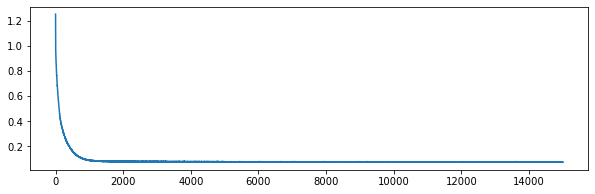

idx 80
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx358/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0008771801537815873 0.005807622905582926
std_all 0.01788485054342673 0.006200579836597678
mean_all -6.178139266406612e-05 0.004891071026745941
std_all 0.020252242764188192 0.02702049157109904
mean_all -0.0006053805667424137 0.005532413382622588
std_all 0.018673981283680554 0.016439157615433127
[0.25140235 0.34774353 0.41361105 0.46608645 0.50689161 0.54153016
 0.56920529 0.59440546 0.61808194 0.63710547 0.65500519 0.67255134
 0.68921538 0.7045916  0.7190775  0.73183577 0.74365365 0.75466939
 0.76453891 0.77385779]
(81, 81)
[0.23410086 0.33418456 0.42988912 0.49077112 0.54007981 0.57373331
 0.60704979 0.63732067 0.6646982  0.68947443 0.70821189 0.72459982
 0.7386621  0.75212848 0.76367632 0.77475395 0.78475971 0.79445501
 0.80342664 0.81220366]
(81, 81)
[0.23815432 0.33640773 0.41132334 0.46449846 0.506084   0.54182318
 0.56942467 0.59648218 0.6224

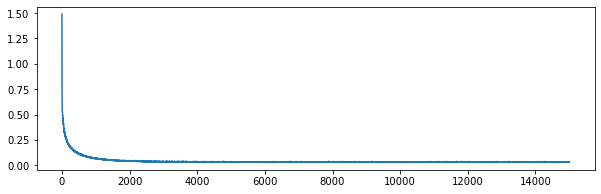

idx 85
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx358/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -7.184108925242948e-05 0.008784698478055466
std_all 0.02135737838665942 0.007279238913313393
mean_all -0.0008592415737043186 0.011897193181365943
std_all 0.0270500962087046 0.01228045883374287
mean_all -0.0003343079174030591 0.0099381150679378
std_all 0.023254950994007817 0.009633085318878874
[0.25006348 0.35664393 0.42674561 0.48389633 0.52488863 0.5603372
 0.59009371 0.61858044 0.64174532 0.66197491 0.6801936  0.69763708
 0.71443955 0.7293159  0.7416624  0.75382857 0.76490153 0.77576205
 0.78591483 0.79573443]
(81, 81)
[0.42657117 0.5628726  0.63503385 0.69682203 0.72678598 0.75311106
 0.77670561 0.79784565 0.81248973 0.82516315 0.83526288 0.84480887
 0.85368707 0.86149503 0.86877624 0.87600615 0.88293021 0.88903219
 0.89444876 0.89982467]
(81, 81)
[0.3063442  0.41915528 0.48826982 0.54482248 0.58148189 0.61468303
 0.64143182 0.66

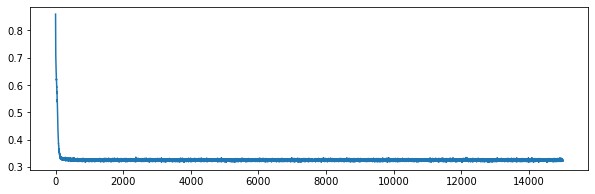

idx 90
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx359/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.002637979258844087 0.01541055661004592
std_all 0.012602388797598132 0.002993690420038285
mean_all -0.002526567626257894 0.008536254460470398
std_all 0.013007923712372652 0.0071386055151221395
mean_all 0.0009164636304767601 0.013730984992940096
std_all 0.012737567102522973 0.004795612314304412
[0.37286392 0.41250534 0.4486652  0.48223362 0.50074767 0.51742754
 0.53205599 0.54481487 0.55702959 0.56868107 0.57968072 0.58996619
 0.59995252 0.60937742 0.61808603 0.6266224  0.63510228 0.64342213
 0.65163029 0.65968363]
(81, 81)
[0.23210629 0.29833206 0.33787319 0.37203714 0.39743571 0.41896035
 0.4377618  0.45469532 0.47013455 0.48441717 0.49785413 0.51083064
 0.52294217 0.53478498 0.54646418 0.55779313 0.56897537 0.5794517
 0.58982057 0.60008593]
(81, 81)
[0.33583894 0.38129496 0.41825405 0.45407594 0.47406295 0.49168165
 0.50771563 0.52098089 0.53376915

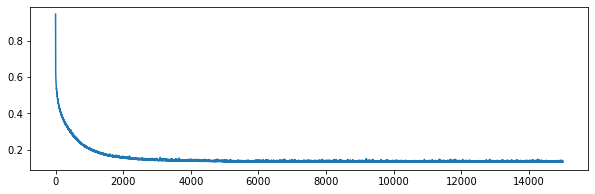

idx 95
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx359/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00011646705931365965 0.012192135953032293
std_all 0.029476571890293856 0.010674573840889101
mean_all -0.0011482591080920525 0.015213041586952018
std_all 0.034526290873953695 0.01535720352276601
mean_all -0.0004603977422397906 0.013284611679291758
std_all 0.031159811551513802 0.012658811528621314
[0.23697671 0.34223225 0.41043303 0.47719018 0.51876693 0.55341185
 0.58534109 0.6163188  0.64091927 0.66396713 0.68546474 0.70483814
 0.72122093 0.73692511 0.75249018 0.76654922 0.77887773 0.78977581
 0.80018262 0.81038231]
(81, 81)
[0.41383096 0.54884592 0.62670666 0.68969598 0.72064032 0.74956656
 0.77050494 0.78989488 0.80568323 0.82130409 0.83566148 0.84584211
 0.85554666 0.86438132 0.87241993 0.87969966 0.88622455 0.89245516
 0.89833281 0.90326159]
(81, 81)
[0.29304509 0.40604654 0.47505137 0.53675235 0.57537815 0.60585644
 0.6351179

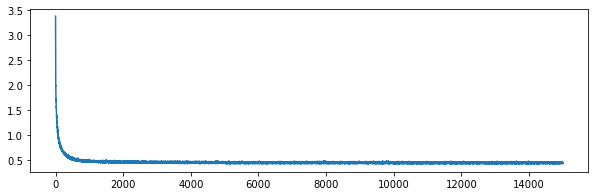

idx 100
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx422/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0010081370959718363 0.00427212482863543
std_all 0.01869739311546536 0.016553882756111773
mean_all -0.00024710547442441665 0.0019929341310418592
std_all 0.018179951182515905 0.020296326038245147
mean_all -0.0007544598887893631 0.003690528431278352
std_all 0.018524912471148874 0.017890233990391895
[0.16660585 0.2744418  0.34813872 0.40954576 0.46454658 0.51698601
 0.55759894 0.59089586 0.62145309 0.65089605 0.67980869 0.70178786
 0.72257474 0.74111505 0.75962454 0.77689617 0.79307691 0.80785737
 0.82038693 0.83247034]
(81, 81)
[0.18659676 0.35956705 0.48559469 0.5797912  0.64603184 0.69068319
 0.73376888 0.77195751 0.80476618 0.83217274 0.85674007 0.8737826
 0.88862368 0.90081111 0.91249899 0.92296307 0.93165248 0.9387492
 0.94553166 0.9516852 ]
(64, 81)
[0.16363281 0.28184538 0.35906368 0.42626562 0.48466985 0.52970776
 0.56981637 0.60462806 0

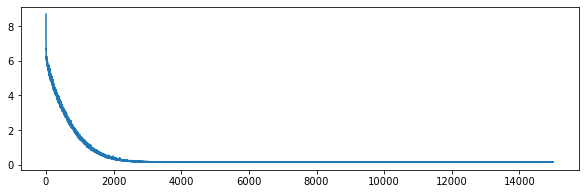

idx 105
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx423/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all 0.00026399405912980455 0.008367917538069498
std_all 0.025482971153214472 0.008673173731985577
mean_all 0.0030299573509806367 0.010137379908418334
std_all 0.031166386539598426 0.011217557250257436
mean_all 0.0011859818230800818 0.00909048821345165
std_all 0.02737744294867579 0.009963527088603428
[0.20451481 0.33625438 0.41518185 0.481934   0.53818054 0.58162478
 0.61787121 0.65110523 0.67831834 0.7035019  0.72541016 0.74620501
 0.76582432 0.78456    0.80097355 0.81597584 0.82824184 0.83971366
 0.85079131 0.86113892]
(81, 81)
[0.33789761 0.49493141 0.58635641 0.67055209 0.74295058 0.78572329
 0.81796048 0.84866203 0.86998211 0.8858276  0.90037473 0.91201725
 0.92267067 0.9322367  0.94060985 0.94794888 0.95455667 0.95971445
 0.96475683 0.96872841]
(64, 81)
[0.24185646 0.36743054 0.45153706 0.51547667 0.57120152 0.61028276
 0.646145   0.67

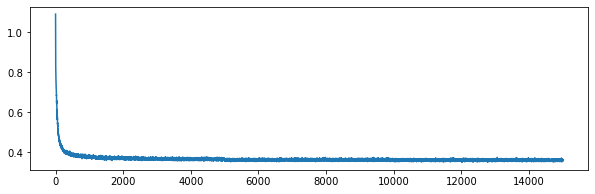

idx 110
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx423/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.00010853211161190868 0.005419121137846755
std_all 0.018504859961327023 0.008132638389899567
mean_all 0.0006325325242484826 0.0042681553125708946
std_all 0.023149888270938647 0.023750479759320813
mean_all 0.00013848943367488834 0.005076646381505459
std_all 0.020053202731197563 0.015392087741842196
[0.19972051 0.30042407 0.36735711 0.42833946 0.48219548 0.53013266
 0.57162756 0.60860849 0.64084738 0.66794037 0.69182181 0.71379855
 0.7337189  0.75242147 0.77034488 0.78586766 0.80083583 0.81475705
 0.82746002 0.83951099]
(81, 81)
[0.24515614 0.37855403 0.49328751 0.56813177 0.63229158 0.68552236
 0.72334612 0.75705897 0.78537769 0.8120696  0.83686526 0.85703308
 0.87228287 0.88657126 0.89834797 0.90926203 0.91775574 0.92560476
 0.93267176 0.93925123]
(64, 81)
[0.20429652 0.30499004 0.39020844 0.45147469 0.50449404 0.5520597
 0.59174889 0.62850665 

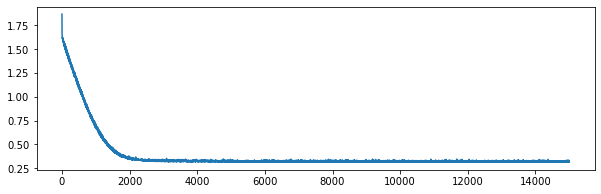

idx 115
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx486/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0019978204293153246 0.012134338729991931
std_all 0.030689337017827983 0.009531442985864306
mean_all 0.00171177345594167 0.014369571900959334
std_all 0.04062208388393405 0.01483847349168507
mean_all -0.0007612891342296599 0.013040232708909786
std_all 0.03400025263986334 0.012485325785182525
[0.21343386 0.29184912 0.36178252 0.42145057 0.4687771  0.51444406
 0.54971186 0.58307762 0.6119305  0.63914538 0.6625815  0.68436886
 0.70533357 0.72449217 0.74162259 0.75768455 0.77284665 0.786605
 0.79966472 0.8115902 ]
(81, 81)
[0.30589229 0.47238522 0.55928197 0.63326446 0.69499542 0.73844949
 0.77873731 0.81449244 0.83976512 0.85813991 0.87335669 0.88495748
 0.89486329 0.90406116 0.91252267 0.92016403 0.92666244 0.93221758
 0.93729124 0.94204714]
(81, 81)
[0.23892438 0.34083856 0.4085069  0.46747328 0.51923841 0.56429313
 0.59855505 0.6314658

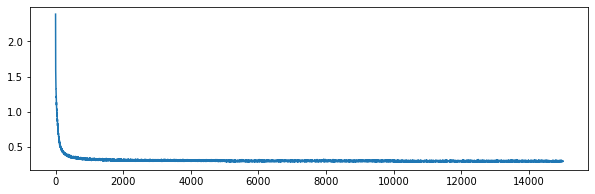

idx 120
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx487/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00021842135328986327 0.006453612619492896
std_all 0.0209254284261403 0.008041516848544344
mean_all 0.00042878276038766164 0.005391117645815006
std_all 0.02294446120672118 0.02638209117473394
mean_all -2.686648730688335e-06 0.0061275778230467015
std_all 0.021598439353000595 0.016613893617981903
[0.22319712 0.32775531 0.41811613 0.47362914 0.52484453 0.56480827
 0.59653805 0.62376284 0.64710065 0.66884338 0.68840097 0.70624179
 0.72227277 0.73703221 0.75127748 0.76488131 0.77718983 0.78822515
 0.79879791 0.80880349]
(81, 81)
[0.24123852 0.3675672  0.46456714 0.53443913 0.59300385 0.64215123
 0.68786758 0.7210586  0.74852813 0.7696404  0.78909895 0.80697108
 0.82144589 0.83445519 0.84524545 0.8547739  0.86367447 0.87194027
 0.87984047 0.88706603]
(81, 81)
[0.22605972 0.32894859 0.41965639 0.47471234 0.52524639 0.5629104
 0.59893785 0.62843581 0.6548

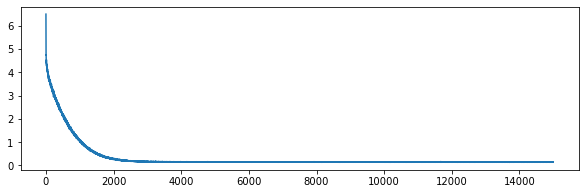

idx 125
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx487/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all 0.00011792883632195914 0.009011650150024246
std_all 0.024165595950727474 0.007784745672366761
mean_all 0.0011385841988315706 0.010396335819702684
std_all 0.029984854512981746 0.010475864909153837
mean_all 0.0004581472904918297 0.009507855820464877
std_all 0.02610534880481223 0.009192825513614526
[0.20455467 0.31938767 0.38886842 0.45104265 0.49898517 0.53714286
 0.57243269 0.60523199 0.63108348 0.65532096 0.67611026 0.69604729
 0.71314066 0.72999273 0.74550777 0.75999237 0.7740169  0.78611174
 0.7969295  0.80737236]
(81, 81)
[0.32537347 0.47858881 0.55995371 0.63515626 0.69520418 0.74483575
 0.78816403 0.81660901 0.84145665 0.86015434 0.87756002 0.8895126
 0.89941045 0.90862553 0.91643454 0.9239247  0.9299204  0.93538217
 0.94013212 0.9444688 ]
(81, 81)
[0.23978379 0.36090064 0.4256557  0.48960393 0.53933553 0.57826361
 0.61458424 

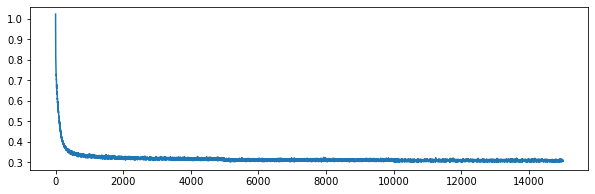

idx 130
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx550/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.00024155921796637633 0.009294196505724241
std_all 0.023168589125370773 0.008345463952139571
mean_all 0.0006899082436273378 0.008445486050134728
std_all 0.027325383705408206 0.026104234745354053
mean_all 0.0003910088931866969 0.009022646013034728
std_all 0.024554187318716586 0.01665576879956702
[0.19659147 0.29183156 0.36582621 0.41657391 0.46098801 0.49709841
 0.5308556  0.55967068 0.58318772 0.60602405 0.6267636  0.64575413
 0.6624974  0.67772283 0.69243966 0.70554492 0.7178311  0.72979366
 0.74135642 0.75175759]
(81, 81)
[0.22378686 0.34346939 0.42894625 0.49138769 0.54207472 0.58239365
 0.61734262 0.64919592 0.67366068 0.69644375 0.71632234 0.73363098
 0.74921588 0.76338358 0.77545998 0.78734243 0.79721982 0.80656476
 0.81554761 0.82440755]
(81, 81)
[0.20318905 0.3000203  0.37731119 0.42943757 0.47567419 0.51052218
 0.54340458 0.57117293 0.59691

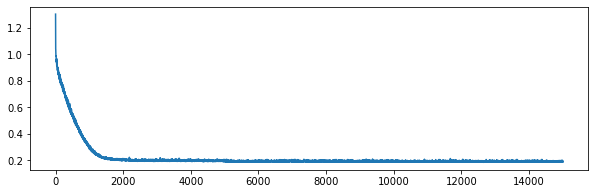

idx 135
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx550/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0002868344240197393 0.012041956713712401
std_all 0.026895050134142832 0.008753002722397563
mean_all 0.001256487275744079 0.01418012350173046
std_all 0.03400014971320939 0.014163819892862814
mean_all 0.00022760614256820015 0.012815111393630604
std_all 0.02926341666049835 0.0113651348033217
[0.19325867 0.29466999 0.3791689  0.44000864 0.48552935 0.52389425
 0.55793422 0.59001044 0.61748017 0.6422846  0.66342066 0.68226613
 0.70071954 0.71783981 0.73363879 0.74752131 0.76004078 0.7722521
 0.78412946 0.79496127]
(81, 81)
[0.3356013  0.47824519 0.55802612 0.61750101 0.66622399 0.70472622
 0.73727381 0.76385327 0.78807915 0.8056402  0.82272517 0.83624235
 0.8479608  0.85811266 0.8676137  0.87507695 0.88233509 0.88917527
 0.89543654 0.90134411]
(81, 81)
[0.23530212 0.34520629 0.41916106 0.48232886 0.52474124 0.56205896
 0.59339338 0.623

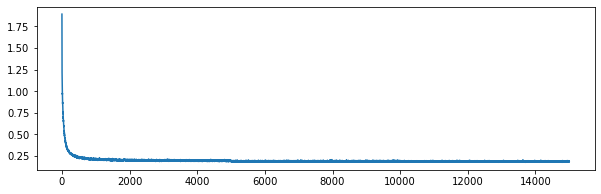

idx 140
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx551/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0006409852877792119 0.007735460855220914
std_all 0.020155114121669412 0.007480109098908312
mean_all 0.0007153348756725535 0.008139563038808926
std_all 0.023669197016501144 0.0218672671723005
mean_all -0.0001888785666286234 0.007898387993169064
std_all 0.02132647508661332 0.014122251436522423
[0.21349902 0.30824346 0.38470645 0.44158374 0.4810219  0.51245683
 0.54007142 0.56622056 0.58774671 0.60721837 0.62652793 0.6440234
 0.6607518  0.67670633 0.69037896 0.70293185 0.71453092 0.72569898
 0.73650133 0.74616578]
(81, 81)
[0.31088014 0.40829354 0.4784766  0.53894955 0.58693622 0.62036821
 0.65192509 0.68045138 0.70573691 0.72262315 0.73785641 0.75199709
 0.76536373 0.77680811 0.78782735 0.79769369 0.80730639 0.81597738
 0.82411112 0.83190883]
(81, 81)
[0.24362806 0.33072552 0.40796112 0.46315275 0.50357542 0.53348843
 0.56105067 0.58784844 0.61

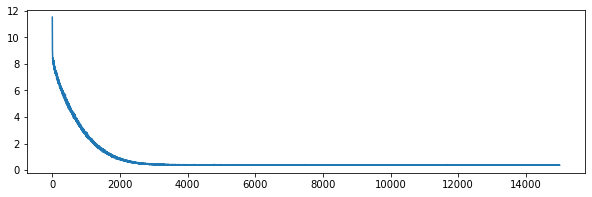

idx 145
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx614/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00030232603190848535 0.011744844702349901
std_all 0.02970580104298872 0.01052876465702296
mean_all 0.0026483056380579547 0.010865473439787375
std_all 0.03180398509896852 0.010790312391941684
mean_all 0.0006812178580803274 0.011543330234910028
std_all 0.03040519572831532 0.010662637720514569
[0.22626535 0.33332572 0.40342744 0.46771209 0.52114767 0.56763367
 0.60824222 0.64316184 0.67318574 0.69835216 0.72070523 0.74239723
 0.76130897 0.77856689 0.79478268 0.80999719 0.82425477 0.83722278
 0.84920393 0.85968877]
(81, 81)
[0.31365395 0.43761289 0.53661968 0.62412337 0.69311185 0.73354643
 0.76761808 0.79781873 0.82300437 0.84783931 0.87050129 0.88798341
 0.90161569 0.91303834 0.92194322 0.93067955 0.93865352 0.94572916
 0.95241651 0.9579591 ]
(64, 81)
[0.24518973 0.34628769 0.41919298 0.48102135 0.53105771 0.57926589
 0.62113658 0.655

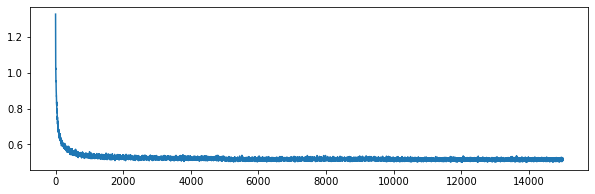

idx 150
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx614/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.001218373472465326 0.007675271402469768
std_all 0.024753399831608347 0.025604524242433466
mean_all 0.0005392682244567784 0.0038933353112205215
std_all 0.023561246364219527 0.025268081163065205
mean_all -0.0006324929068246242 0.006709127570504476
std_all 0.024356015342478738 0.025499063614305404
[0.2027928  0.30469051 0.39366295 0.4566573  0.50484191 0.54902432
 0.59104407 0.62758492 0.66132868 0.6880999  0.7109471  0.73269716
 0.75236793 0.77114443 0.78802419 0.802695   0.81608385 0.82868667
 0.84016927 0.85088287]
(81, 81)
[0.23958309 0.40725334 0.494128   0.57510795 0.63567233 0.67728786
 0.71399841 0.74771889 0.77822432 0.80461142 0.82834864 0.84948925
 0.86826951 0.88080317 0.89272232 0.90329579 0.91345394 0.92213549
 0.93002574 0.93713219]
(64, 81)
[0.19944793 0.3126844  0.39860675 0.46040422 0.51216178 0.55596908
 0.59343752 0.62596426 0

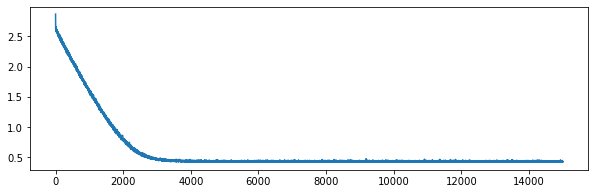

idx 155
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx615/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00013396334310750076 0.012146481582813486
std_all 0.03514430603729877 0.013985724138229662
mean_all 0.0017026884093054079 0.01437375231992775
std_all 0.0446789402717996 0.01907587181631142
mean_all 0.0004782539076968019 0.012960550981227316
std_all 0.03832251744879905 0.016489350215121754
[0.25001149 0.34718132 0.41783642 0.48061799 0.53054336 0.57167702
 0.60859683 0.64448462 0.67248483 0.69667096 0.71902002 0.74010826
 0.7578967  0.77537949 0.79080138 0.80541118 0.81926672 0.83094027
 0.84239133 0.85364159]
(81, 81)
[0.27171781 0.45415292 0.55039031 0.64004477 0.69434468 0.74408586
 0.78288108 0.81429218 0.83911872 0.86188463 0.88274327 0.9003074
 0.9140707  0.9264856  0.93601093 0.94509547 0.95312944 0.95851121
 0.96330409 0.96762618]
(64, 81)
[0.24404327 0.35640815 0.43271313 0.49068246 0.54555962 0.59175252
 0.63068526 0.6619700

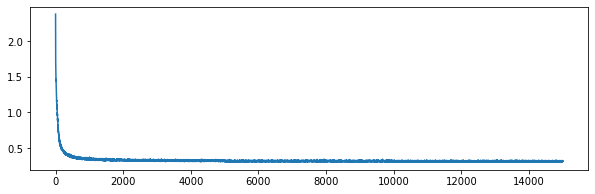

idx 160
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx678/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.000348872404161062 0.007767923721828703
std_all 0.024213954815747105 0.033875836483278826
mean_all 0.0001312737001903853 0.005337050469796604
std_all 0.022861956261489187 0.026104153413497935
mean_all 0.00027633950283750315 0.007052114381377659
std_all 0.023763288630994462 0.03150550227277558
[0.21818262 0.31197887 0.38403581 0.4479681  0.49738483 0.53890976
 0.57325526 0.60103536 0.62622223 0.64936626 0.67126559 0.69064358
 0.70740568 0.72291541 0.73767163 0.75176985 0.76490621 0.7767663
 0.78788666 0.79797963]
(81, 81)
[0.26193129 0.38128443 0.4752203  0.54270411 0.60727522 0.66080589
 0.69893341 0.73341216 0.76214718 0.78355386 0.80413366 0.82104168
 0.83349153 0.84507457 0.85589757 0.86601752 0.87546242 0.88384816
 0.89111687 0.89735585]
(81, 81)
[0.22645882 0.32311732 0.39911572 0.4608446  0.51133085 0.55313309
 0.58656929 0.61641735 0.643820

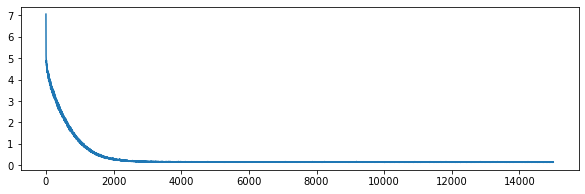

idx 165
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx678/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0007019622235409017 0.009590293005797071
std_all 0.023243798076309927 0.0077774046441935075
mean_all 0.0007488364058358118 0.011257907379210643
std_all 0.030032284850336953 0.010834670813220133
mean_all -0.0002183626804153305 0.010199528249574968
std_all 0.025506627000985604 0.009470806126970448
[0.23935231 0.32166631 0.40019562 0.46674362 0.50913487 0.54801728
 0.58454485 0.61217736 0.63766287 0.65950259 0.68033558 0.70002249
 0.71781124 0.73464975 0.74977825 0.76409175 0.77731409 0.78900507
 0.80040427 0.81126723]
(81, 81)
[0.37034029 0.49268467 0.58495932 0.65605913 0.72223135 0.76781891
 0.80636389 0.83505604 0.86066986 0.87854222 0.89293591 0.90384832
 0.91338145 0.92123254 0.92861639 0.93503783 0.9400302  0.94479896
 0.94870665 0.95246015]
(81, 81)
[0.274376   0.36209413 0.43633201 0.49947994 0.55049194 0.5943604
 0.626778

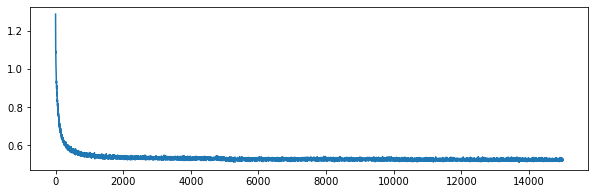

idx 170
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx679/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.00010183232486465994 0.00728905076534802
std_all 0.020477670235173953 0.007396776363980663
mean_all 0.00010377628724745308 0.005072239797360746
std_all 0.023498964714037566 0.02939666468297074
mean_all 0.00010248031232559092 0.006632951610479752
std_all 0.021484768394795156 0.01807091563681984
[0.19883111 0.29980075 0.37639067 0.43188931 0.47412304 0.50934099
 0.5441572  0.57664557 0.60477148 0.63182289 0.65696162 0.67892259
 0.69715876 0.71454997 0.73078036 0.74649967 0.76104489 0.77394641
 0.78560174 0.79651683]
(81, 81)
[0.22798034 0.36012567 0.46049136 0.54287867 0.60845689 0.65356344
 0.69325104 0.73094922 0.76334869 0.79335282 0.81146315 0.82754303
 0.84204449 0.85488897 0.86665815 0.87688351 0.88651814 0.89519453
 0.90222054 0.90849346]
(81, 81)
[0.20457675 0.30519909 0.3839439  0.44483686 0.49260512 0.53279812
 0.56885517 0.60126511 0.62914

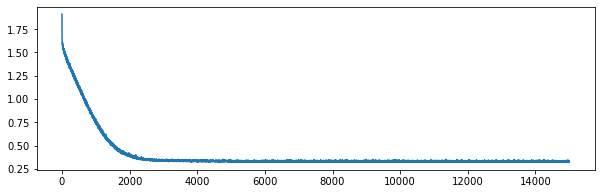

idx 175
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx679/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0002940081003393048 0.011962209151863959
std_all 0.03022946341607844 0.010137447380623957
mean_all 0.0005359626782779044 0.01316770401760675
std_all 0.03658409344237366 0.014022670895687659
mean_all -1.7351174133568364e-05 0.01238327580529587
std_all 0.032347673424843515 0.011959540956714573
[0.20540038 0.29693711 0.36854691 0.42586231 0.46991633 0.5113849
 0.54932036 0.58308207 0.61419065 0.64185785 0.6674602  0.68879843
 0.70823072 0.72683645 0.74387201 0.75918208 0.77332625 0.7871244
 0.80001518 0.81147328]
(81, 81)
[0.31194487 0.45821296 0.55605664 0.6327835  0.70104852 0.74602847
 0.78834686 0.81765495 0.84521448 0.86731443 0.88171818 0.89452629
 0.90598163 0.91613537 0.92528058 0.93323243 0.94017224 0.94517674
 0.94958762 0.95343641]
(81, 81)
[0.23630827 0.33859563 0.40614394 0.46941463 0.5149557  0.55628301
 0.59209463 0.6

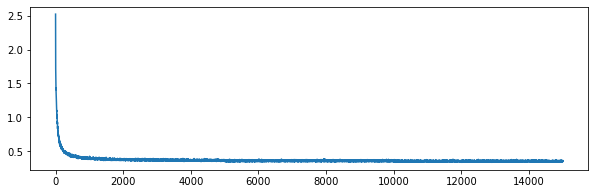

idx 180
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx742/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00013225051852315512 0.007057313358354494
std_all 0.01983366599467201 0.007819074034071056
mean_all 0.00025830080713030166 0.005800672543776602
std_all 0.020985166924560095 0.024661897630276045
mean_all 0.000174267281392204 0.0066650765958667785
std_all 0.020217499637968036 0.015613765313777233
[0.20156454 0.29101363 0.37007987 0.42735552 0.46768432 0.50174576
 0.53188608 0.55885865 0.58246582 0.60291283 0.62331976 0.64156499
 0.65790456 0.67347852 0.68868761 0.70210381 0.714705   0.72685411
 0.7373734  0.74747966]
(81, 81)
[0.24543814 0.35592638 0.42970487 0.50038151 0.55554001 0.60087059
 0.63989165 0.67496794 0.70826408 0.72926906 0.74718839 0.76248863
 0.77639782 0.78950126 0.80053197 0.8113184  0.8207937  0.82973714
 0.83847415 0.84620269]
(81, 81)
[0.21089477 0.29636116 0.38110745 0.44041496 0.48223536 0.51632709
 0.54730377 0.57628851 0

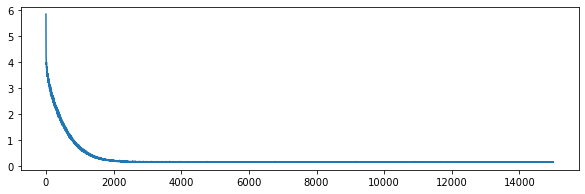

idx 185
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx743/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00017689584481603342 0.008556661933637959
std_all 0.024164652969466724 0.009523115594725589
mean_all 0.0011756044909249112 0.011316532722754322
std_all 0.028490739315250858 0.011771378883660753
mean_all 0.0002739376004309481 0.00958673292507979
std_all 0.02560668175139477 0.010526498375229992
[0.16780338 0.25591629 0.32505119 0.3833181  0.42880723 0.46711459
 0.50084741 0.5317675  0.56035228 0.58571569 0.60893144 0.63038361
 0.65060198 0.6698416  0.68627349 0.70214296 0.71695927 0.73068995
 0.74370994 0.75598507]
(81, 81)
[0.35334377 0.49284802 0.57921841 0.63757029 0.69237372 0.73369629
 0.76509808 0.79416463 0.81796794 0.83458104 0.84687987 0.85793061
 0.86735268 0.87621675 0.88361831 0.89018713 0.89641331 0.90256506
 0.90791973 0.91299835]
(81, 81)
[0.22523537 0.32597509 0.39674981 0.45548152 0.49612252 0.53021105
 0.56104517 0.5

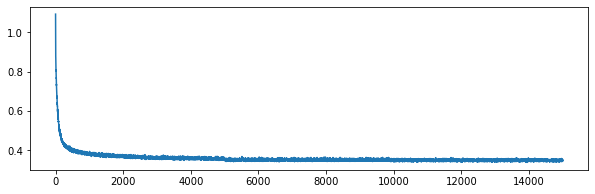

idx 190
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx743/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0001771888669152838 0.00679893995697642
std_all 0.02089922904568351 0.012973419572080022
mean_all 0.00027938734978955444 0.006120557457990115
std_all 0.02122536819951011 0.02647308746566268
mean_all -2.4996794680337718e-05 0.006584106298119396
std_all 0.02100794209695904 0.01859672463917764
[0.17955274 0.26436618 0.33987063 0.39573279 0.43404898 0.46648813
 0.49706333 0.52710066 0.55403771 0.57527369 0.59624046 0.61495197
 0.63247888 0.64930044 0.66467915 0.67932692 0.69341865 0.70598114
 0.71773264 0.72901061]
(81, 81)
[0.26413268 0.38147396 0.46158953 0.5311082  0.58550343 0.62221679
 0.65470514 0.68629278 0.71419138 0.73464254 0.75122813 0.7649842
 0.77825118 0.78956863 0.79904271 0.80840495 0.81690308 0.82486938
 0.83262809 0.84001547]
(81, 81)
[0.20297961 0.28834347 0.36946563 0.42920161 0.47246203 0.50304986
 0.53250876 0.56021059 0.5839

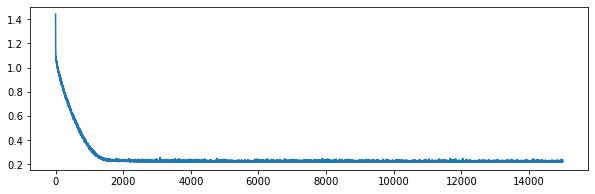

idx 195
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx806/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006933523416111978 0.006267050381062081
std_all 0.026561138079246698 0.009962648487406767
mean_all 0.0017906944070216506 0.006962877694194125
std_all 0.03635265794308421 0.013625035044037156
mean_all 0.00013466324126641826 0.006611786585958335
std_all 0.029824978033859206 0.01222110493114878
[0.15673577 0.24712923 0.32445906 0.38604666 0.44285994 0.49204711
 0.53416824 0.57355356 0.61036288 0.64116588 0.66971855 0.69413681
 0.71600229 0.73724089 0.75669032 0.77499098 0.79179694 0.80708131
 0.82196958 0.83541917]
(81, 81)
[0.26856622 0.44961462 0.60314725 0.72931844 0.80745208 0.88012746
 0.90192104 0.91708883 0.93016429 0.94148265 0.94931327 0.95606874
 0.96179809 0.96632702 0.97048375 0.97427917 0.9774162  0.97982287
 0.98182615 0.98361148]
(64, 81)
[0.16615264 0.28612053 0.40062926 0.48014467 0.5358363  0.58527877
 0.62554965 0.65

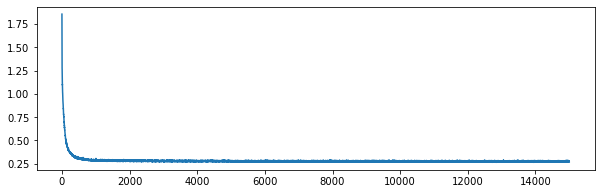

idx 200
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx807/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00021719721076498622 0.00483487160554232
std_all 0.01768667228486 0.012095957466209189
mean_all 0.00013073716971865766 0.0019383347417372963
std_all 0.019478128478646946 0.022824583613626468
mean_all 0.0001883771970828767 0.004103416950717876
std_all 0.01828382434945565 0.01648964861879127
[0.17918964 0.28862535 0.36731745 0.43407986 0.48799754 0.5364602
 0.57421879 0.60645272 0.63617983 0.661445   0.68453055 0.70639018
 0.72658395 0.74496921 0.76194953 0.77701827 0.79181006 0.80531904
 0.81723703 0.82811436]
(81, 81)
[0.20846699 0.35396541 0.47364514 0.57794623 0.64867922 0.70306906
 0.74420326 0.77942159 0.80797076 0.83230816 0.85346175 0.87057499
 0.88560601 0.89741963 0.90712719 0.91624849 0.92507511 0.93247493
 0.9398478  0.94629837]
(64, 81)
[0.16101881 0.29673516 0.38413052 0.45483364 0.50538966 0.55088507
 0.59357546 0.62579804 0.65465745 

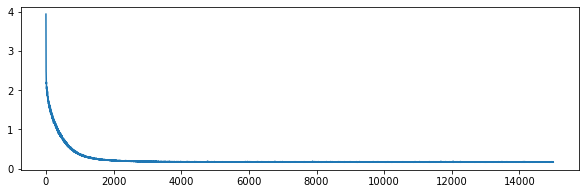

idx 205
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx807/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0005554490162281997 0.009250401438383092
std_all 0.02693114408023585 0.012528711197210081
mean_all 0.001060353602472009 0.006933420602806753
std_all 0.028715649387731638 0.009730041354970588
mean_all -1.6848143328130223e-05 0.008582010646300344
std_all 0.027525979182734445 0.011700910022880264
[0.22293479 0.33142811 0.41615832 0.48151851 0.53045442 0.56893798
 0.60572077 0.6416487  0.67107441 0.69697723 0.71913432 0.73849887
 0.75668301 0.77365997 0.78898742 0.80295629 0.81559882 0.82731299
 0.83863169 0.84927466]
(81, 81)
[0.21720916 0.41025907 0.55275662 0.66315412 0.7374795  0.79533448
 0.83252743 0.86543658 0.88583064 0.90156215 0.91577026 0.92697705
 0.93618615 0.94523495 0.95235233 0.95744924 0.96207036 0.96641088
 0.97010723 0.97350681]
(64, 81)
[0.2146591  0.34280434 0.43574363 0.51740862 0.56961232 0.61246459
 0.6521386

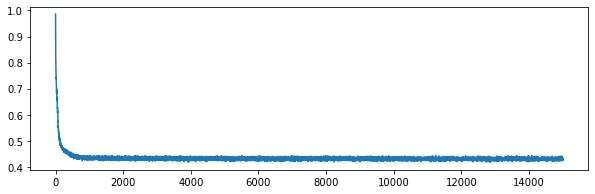

idx 210
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx870/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0005153489330757994 0.011450432786826783
std_all 0.01613939694739573 0.008371841644146841
mean_all -0.0014188355895447735 0.006726671653581148
std_all 0.01976382984462642 0.018793040300751886
mean_all -0.00012937924113105829 0.010164759056958577
std_all 0.017347541246472628 0.01293717517671947
[0.25304585 0.33274103 0.38542444 0.43150494 0.46825804 0.49811164
 0.5250654  0.54736717 0.56839567 0.58851876 0.60650767 0.62249766
 0.63701836 0.65068359 0.66426835 0.67754607 0.68921586 0.7003911
 0.71074646 0.72079096]
(81, 81)
[0.20944374 0.30892583 0.39350726 0.44936126 0.50314251 0.53845157
 0.56695823 0.59213457 0.6148514  0.63411783 0.65154571 0.66771096
 0.68199011 0.69559173 0.70868122 0.72113945 0.73224379 0.74312115
 0.75342797 0.76344294]
(81, 81)
[0.2266225  0.31037264 0.37858399 0.42657661 0.46995972 0.4992515
 0.52541585 0.54915332 0.5695483

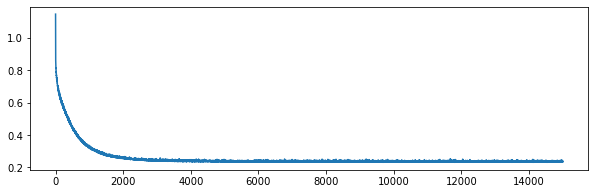

idx 215
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx870/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0005025554041467365 0.01033323704944402
std_all 0.03061370477885607 0.009682914986807742
mean_all 0.00034976131270156476 0.011333656063078578
std_all 0.034986607230614086 0.012680802406432564
mean_all -0.00021844983186396943 0.010684687352365154
std_all 0.03207133892944207 0.010970697620725941
[0.22620663 0.33302604 0.40618557 0.46583099 0.51643952 0.5596464
 0.59831139 0.62974228 0.65545241 0.6789679  0.70004827 0.72007527
 0.73644624 0.75232854 0.76600875 0.77930715 0.79200907 0.80438576
 0.81566713 0.82637333]
(81, 81)
[0.33576476 0.53877701 0.66529038 0.74918878 0.79764721 0.83212983
 0.85786128 0.87707233 0.89329717 0.90791915 0.91931242 0.92630544
 0.9328084  0.93819734 0.94302633 0.9474537  0.95167712 0.95518384
 0.95864626 0.96138672]
(81, 81)
[0.25772169 0.39547755 0.47571392 0.54419487 0.58951697 0.62803552
 0.6661418  

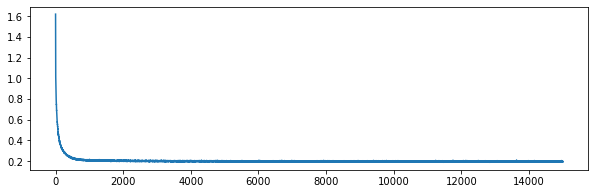

idx 220
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx871/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00011417651932292092 0.004052737167854109
std_all 0.015579313623382565 0.0067829754110215615
mean_all 6.003387970171179e-05 0.0023513732925342316
std_all 0.014304977875041409 0.022866897629497427
mean_all 9.612897278251792e-05 0.003576789423858233
std_all 0.015154535040602183 0.014329400302842344
[0.2260841  0.33889013 0.42491287 0.48415002 0.53729466 0.57399605
 0.60831427 0.63939375 0.66416801 0.6871732  0.70718614 0.72543191
 0.74329001 0.75994185 0.77269598 0.78535761 0.79685448 0.80788953
 0.8182076  0.82756321]
(81, 81)
[0.23977698 0.40157398 0.51346908 0.59152613 0.64266009 0.68176005
 0.71593962 0.74693546 0.76903464 0.78735922 0.80428425 0.81861151
 0.83089802 0.84224539 0.85319886 0.86302894 0.87184536 0.87960526
 0.88731876 0.89489865]
(81, 81)
[0.22406978 0.34479641 0.44184401 0.50400529 0.551822   0.5898534
 0.62435511 0.65554846 

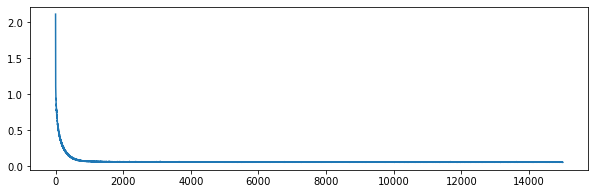

idx 225
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx934/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0003325670392446923 0.007954190405640606
std_all 0.022154196503127277 0.007270527728548094
mean_all -8.64887433881845e-05 0.011621774481709469
std_all 0.02925242481966316 0.011966985375915033
mean_all -0.0002505409406258564 0.009338884690854173
std_all 0.024520272608639235 0.00970429085015121
[0.21374018 0.32204716 0.39376084 0.4562418  0.49672046 0.53488334
 0.57019196 0.59976569 0.62436622 0.64798713 0.66821751 0.68718506
 0.70474169 0.7200697  0.73451329 0.748084   0.75988297 0.77112767
 0.78141879 0.79158765]
(81, 81)
[0.40707765 0.59152833 0.68560528 0.76259428 0.79901651 0.82280351
 0.84044208 0.85783037 0.87483973 0.88442835 0.89270456 0.90037748
 0.90685908 0.91249987 0.91756287 0.92203616 0.92636599 0.93039534
 0.93408081 0.93747656]
(81, 81)
[0.2744802  0.40422413 0.47821377 0.54260006 0.57771829 0.61127015
 0.64203309 0.6

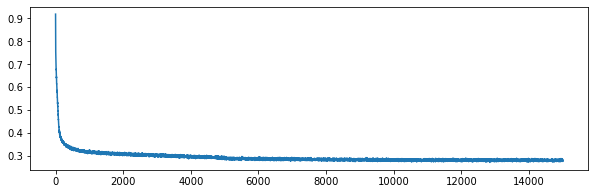

idx 230
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx934/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0006440274484427494 0.011133423384498535
std_all 0.02230074037497895 0.020018052599211432
mean_all -0.0005832102229431669 0.010855066610638299
std_all 0.023873081344093803 0.03741638801513264
mean_all -0.0006237550399428884 0.011041454757136405
std_all 0.022824854031350567 0.027099072078685178
[0.26671489 0.34925686 0.42453894 0.47399286 0.51776426 0.54905315
 0.57649601 0.6027246  0.62533661 0.64420592 0.66182579 0.67908625
 0.69560581 0.71024451 0.72432419 0.73615212 0.74721745 0.75708447
 0.76650777 0.7759114 ]
(81, 81)
[0.26965704 0.41059824 0.49561916 0.5674173  0.61196699 0.64323399
 0.6735634  0.69870527 0.72284981 0.74252702 0.75908845 0.77284456
 0.78515434 0.79654228 0.80639618 0.81551099 0.82385317 0.83199901
 0.83943838 0.84662685]
(81, 81)
[0.26264932 0.358821   0.43832315 0.49270311 0.53428183 0.56607564
 0.59348421 0.6194119  0.

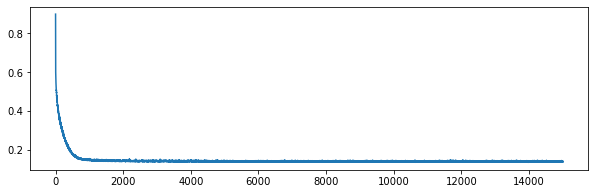

idx 235
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx935/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006908268164079723 0.010114854837667919
std_all 0.025681309661569722 0.00872286219327053
mean_all -0.0005038018839772123 0.013122225097743554
std_all 0.033026106303114255 0.014120519912624974
mean_all -0.0006284851722643855 0.011207686159857828
std_all 0.02812957520875123 0.011365587789837518
[0.22100579 0.32443725 0.39463356 0.45665486 0.50049236 0.53597006
 0.57028538 0.600412   0.62621428 0.64809077 0.66782535 0.68655984
 0.70477391 0.72027509 0.73560394 0.74941528 0.7622801  0.7740859
 0.78546604 0.7958717 ]
(81, 81)
[0.40212429 0.57526346 0.67666968 0.75355671 0.7834693  0.81025508
 0.83047182 0.8485504  0.86468544 0.87574502 0.88473316 0.89254507
 0.89942773 0.90544143 0.91077605 0.91562393 0.9200207  0.92427068
 0.92832627 0.93213769]
(81, 81)
[0.27723825 0.397947   0.4752039  0.53760529 0.5758214  0.60888115
 0.6391355  0.66

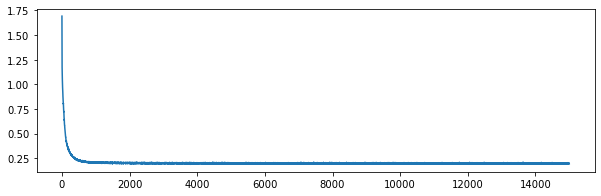

idx 240
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx998/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0006793836267151164 0.004326656969401438
std_all 0.018066465998415986 0.019384269007415616
mean_all -0.00043601068981003464 0.0018288129448544475
std_all 0.01762652199677576 0.021806115829775676
mean_all 0.0003075855212067327 0.003724418560284053
std_all 0.017919817997869247 0.020224864987614354
[0.13959792 0.22890831 0.31622514 0.38863424 0.44369413 0.49431986
 0.53806848 0.57544255 0.60759412 0.63549223 0.66031119 0.68486067
 0.70781652 0.72875921 0.74723764 0.76366456 0.77867684 0.79287465
 0.80646483 0.81906773]
(81, 81)
[0.21304849 0.35281759 0.47314151 0.55814574 0.64199739 0.70347597
 0.74131737 0.77260424 0.80028749 0.82492515 0.84640805 0.86255342
 0.87712065 0.89025821 0.90146424 0.91258471 0.92190321 0.93093603
 0.93797127 0.9436156 ]
(64, 81)
[0.15993301 0.25619036 0.34777667 0.41504606 0.47438961 0.52869796
 0.56657484 0.60238356 0.63

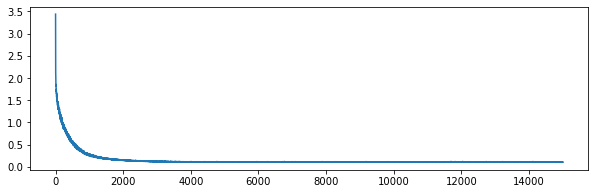

idx 245
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx998/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0003819425696447031 0.006233677211120693
std_all 0.02340641646503756 0.010535563143676454
mean_all -9.737050548653243e-05 0.007325317203488262
std_all 0.02747609499799433 0.010784346140938253
mean_all -0.0002870852149253128 0.006618955677523914
std_all 0.024762975976023154 0.010791042974575874
[0.16205532 0.26942182 0.36735432 0.44088014 0.49731455 0.55103011
 0.59347197 0.62968999 0.66179327 0.6878337  0.71179952 0.73393184
 0.75429305 0.77210704 0.78901863 0.80454314 0.81952169 0.83305871
 0.84428619 0.85513031]
(81, 81)
[0.26895269 0.44943732 0.58889677 0.68750914 0.77902558 0.83086182
 0.86619521 0.88455975 0.90124167 0.91438377 0.92701877 0.93674577
 0.94403934 0.94998516 0.95580951 0.96069035 0.96502316 0.9688189
 0.97193572 0.9747649 ]
(64, 81)
[0.19127374 0.30655667 0.4063823  0.49232526 0.55303002 0.60273197
 0.64569041

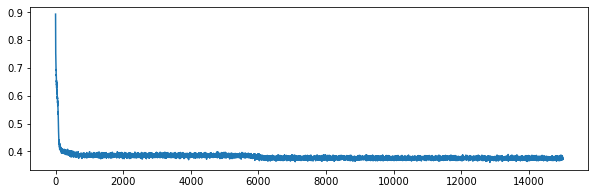

idx 250
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx999/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.002199297986945436 0.0143217350267163
std_all 0.011563806357147089 0.00399907594683568
mean_all -0.0023704280337494095 0.005002187320432542
std_all 0.013611794282212108 0.009542960431991501
mean_all 0.0006760559800471542 0.012236116807891821
std_all 0.012246468998835433 0.0064768685941540265
[0.35556973 0.42361329 0.47500976 0.51986635 0.5526887  0.5830146
 0.60648562 0.62879358 0.64926818 0.66670333 0.68331352 0.69901147
 0.71386562 0.7279706  0.74104776 0.75370342 0.76560969 0.77714939
 0.78814447 0.79873874]
(81, 81)
[0.15208892 0.25755875 0.33231669 0.39097206 0.44460227 0.4833352
 0.5176019  0.55024732 0.57663146 0.60254978 0.62711601 0.65003115
 0.67167842 0.69191954 0.71071983 0.72907198 0.74685607 0.76376427
 0.77992838 0.79537921]
(64, 81)
[0.28641753 0.36007218 0.41295474 0.45689855 0.49609192 0.52825718
 0.55123946 0.57285695 0.59250138 

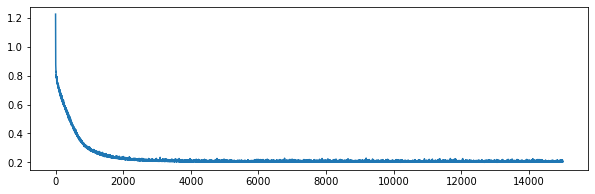

idx 255
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx999/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.001281442463919928 0.01100821829528426
std_all 0.03159230511015036 0.00905808036117234
mean_all -0.0005365049393932759 0.010872422067474031
std_all 0.03532519887626294 0.013334595138329101
mean_all -0.0010331299557443776 0.010968762560059013
std_all 0.03283660303218789 0.010819715508810503
[0.28167657 0.39188531 0.47140626 0.54312252 0.59821349 0.64120004
 0.67376706 0.70411709 0.73233971 0.75603278 0.77659746 0.79585387
 0.81215257 0.82667808 0.83852648 0.85015762 0.86143559 0.87227783
 0.88252488 0.8911067 ]
(81, 81)
[0.27966285 0.45603201 0.59038168 0.70696177 0.76922121 0.80859243
 0.8400889  0.86772381 0.88493081 0.90152821 0.91356757 0.92455939
 0.93498208 0.9416699  0.94778109 0.95341098 0.95805683 0.96218517
 0.96609909 0.9693362 ]
(64, 81)
[0.27438217 0.40152341 0.48761559 0.56976491 0.62406276 0.66332885
 0.69776612 0.7

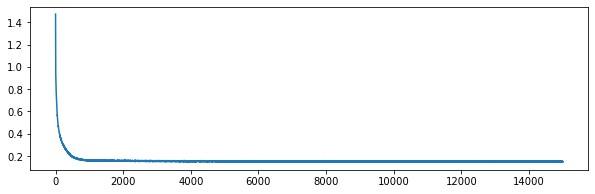

idx 260
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1062/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00011316423037721694 0.00419251954400184
std_all 0.014029555588207267 0.007394525119659483
mean_all -4.774935043143991e-05 0.002950425545642637
std_all 0.014990561359180848 0.0223344438171221
mean_all 5.9526370107664655e-05 0.003824339301299037
std_all 0.014349890845198462 0.014245479659316069
[0.25051386 0.37401219 0.4664246  0.51944185 0.5652083  0.59977091
 0.62973413 0.65863705 0.67951556 0.69946792 0.71743603 0.7347542
 0.75013805 0.76415091 0.77686456 0.78764056 0.7977006  0.80761684
 0.81689893 0.82589947]
(81, 81)
[0.25335874 0.39977012 0.50326877 0.57286855 0.62053614 0.6560039
 0.68612078 0.715185   0.73899681 0.75961395 0.77766196 0.79407138
 0.80838027 0.8204434  0.83094544 0.84100048 0.85045054 0.8585886
 0.86658217 0.87358126]
(81, 81)
[0.24762953 0.37381491 0.4690089  0.52296862 0.56906825 0.60491347
 0.63371743 0.66102966 0.68

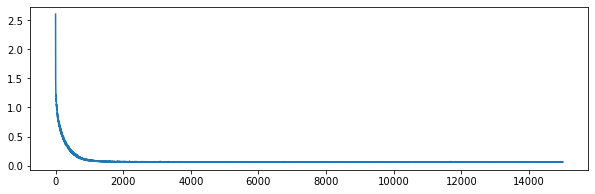

idx 265
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1063/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0006932271648624241 0.008221959273448301
std_all 0.023595853739500905 0.007706606705993276
mean_all 0.000525757932619938 0.009902420901806179
std_all 0.027396065537423138 0.011256248028792767
mean_all -0.0002868987990349701 0.008836473368002813
std_all 0.02486259100547498 0.009221612898213034
[0.22517772 0.34034508 0.4182319  0.48328573 0.52676636 0.56735445
 0.60675693 0.63366646 0.65911964 0.68409723 0.70406508 0.72091195
 0.73734467 0.75367351 0.76856353 0.78215548 0.79497714 0.8056261
 0.81554909 0.82509582]
(81, 81)
[0.34209701 0.5272079  0.6321807  0.71749223 0.77139062 0.79958054
 0.82645382 0.85043224 0.87159905 0.88238131 0.89214158 0.9011467
 0.90897315 0.91607078 0.92298647 0.92825955 0.93275129 0.93701285
 0.94113147 0.94499056]
(81, 81)
[0.26045596 0.39449882 0.47580803 0.54462855 0.58246924 0.61872686
 0.65428065 0.68

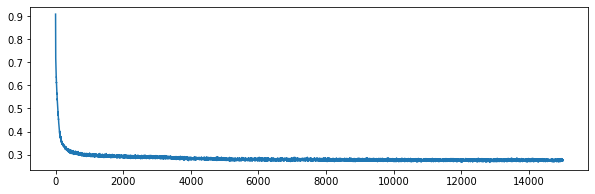

idx 270
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1063/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0011076720711790892 0.014510310151583142
std_all 0.030545651334653215 0.03010662088059811
mean_all -0.000619933748533913 0.013557676490539895
std_all 0.029131586452587274 0.041333314297026774
mean_all -0.0009450926302973639 0.01420172977328227
std_all 0.030074296373964565 0.03426656857378984
[0.23194946 0.33446658 0.42393526 0.47951    0.52918842 0.57130142
 0.6067835  0.63845313 0.66479746 0.68747143 0.70896674 0.72783622
 0.74402737 0.75871677 0.7726647  0.78447628 0.79570557 0.80640302
 0.8161165  0.82535286]
(81, 81)
[0.22703799 0.34777624 0.46383908 0.5380162  0.58440633 0.62478449
 0.66016471 0.69354308 0.72060421 0.74496453 0.76286203 0.77792097
 0.79231021 0.80519801 0.81723568 0.82795527 0.83737128 0.84632783
 0.85475644 0.86297911]
(81, 81)
[0.22709969 0.33332772 0.42898622 0.4883219  0.5349329  0.57515395
 0.6087581  0.6396662  0.6

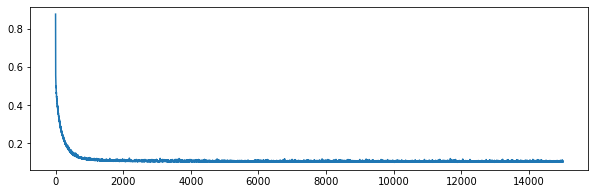

idx 275
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1126/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0005153203612740759 0.008910681442910202
std_all 0.024740521561111506 0.00875230545563862
mean_all 0.0003956087598771952 0.013169301862976672
std_all 0.03303699218332422 0.014503346980042095
mean_all -0.00021167732089031872 0.010532239294788965
std_all 0.027506011768515744 0.011682471081704584
[0.21654593 0.32692805 0.39688355 0.45982529 0.50122801 0.54021678
 0.57465293 0.60437563 0.62797532 0.64905134 0.66789561 0.68647578
 0.70297043 0.71843886 0.73340655 0.74618885 0.75816193 0.7696712
 0.78005839 0.78980709]
(81, 81)
[0.42233534 0.58942074 0.6748433  0.73511646 0.76745042 0.79561268
 0.81989769 0.83902528 0.85478214 0.86575864 0.87504817 0.88228482
 0.88938179 0.89594895 0.90206575 0.90754595 0.91254081 0.917293
 0.9215446  0.92544054]
(81, 81)
[0.28235814 0.41117472 0.48238569 0.54232907 0.57633662 0.60930727
 0.64064402 0.669

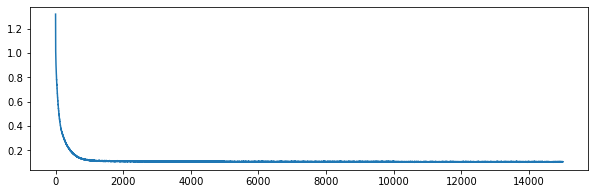

idx 280
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1127/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00012381944176981818 0.006200067846845733
std_all 0.01813661792942861 0.006873853841684158
mean_all 0.00012761900733960805 0.0058798460823087225
std_all 0.02094632999131742 0.028410730475222443
mean_all 0.0001250859636264148 0.006095197076034197
std_all 0.01907318861672488 0.01738708646594958
[0.25652135 0.36115416 0.43277215 0.47957574 0.51855728 0.54969863
 0.57833523 0.60367889 0.62480765 0.64487426 0.66252184 0.67860247
 0.69384611 0.70803649 0.72155437 0.73352889 0.74442041 0.75388799
 0.76316939 0.77205478]
(81, 81)
[0.26683292 0.37744749 0.46579463 0.52527327 0.56885681 0.60465978
 0.63443308 0.66230339 0.68715051 0.7077003  0.72460876 0.73958204
 0.75375083 0.76713764 0.7795443  0.7907211  0.80103428 0.81048555
 0.81912726 0.8271238 ]
(81, 81)
[0.25179953 0.35545135 0.43602263 0.48448018 0.52453809 0.55744301
 0.58741471 0.61210176 0.6357

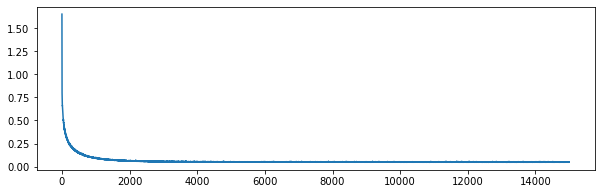

idx 285
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1127/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00028489272742554105 0.009434614800536298
std_all 0.022268167823802486 0.008304082798676674
mean_all -0.0005865350890571102 0.0120972113052389
std_all 0.028301784797627932 0.01215917864191287
mean_all -0.0003854401813027308 0.01039915209645293
std_all 0.024279373481744304 0.010165807013246724
[0.25107092 0.35730264 0.42384001 0.47897942 0.52025343 0.55405874
 0.58628611 0.61653166 0.6380703  0.6583226  0.67841862 0.69613063
 0.71203637 0.72680615 0.74078247 0.75371967 0.76498028 0.77528071
 0.78503138 0.79409232]
(81, 81)
[0.41565297 0.55999758 0.63747143 0.70778181 0.73737837 0.7662721
 0.79074693 0.81225018 0.82490725 0.83567826 0.84578014 0.85523125
 0.86371883 0.87188142 0.87964777 0.88704552 0.89279309 0.89819012
 0.90348459 0.90826659]
(81, 81)
[0.30353039 0.41964399 0.48426525 0.54394004 0.58267694 0.61421642
 0.64207679

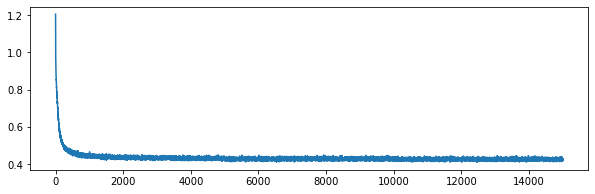

idx 290
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1190/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0007989348027669333 0.006651540357912671
std_all 0.02335726142664081 0.012606906098891034
mean_all 0.0008036494680365 0.0038556024550620953
std_all 0.026585703274596834 0.026764246168709045
mean_all -0.0002647400458324556 0.005917877794935744
std_all 0.02443340870929282 0.018629202824199827
[0.19230146 0.31277207 0.41923295 0.48231219 0.53513165 0.5780945
 0.61427211 0.64592887 0.672863   0.69892535 0.72142706 0.74156767
 0.7595067  0.77667394 0.79224504 0.80611695 0.8195852  0.83249865
 0.84356205 0.85445623]
(81, 81)
[0.21453002 0.34335646 0.4613015  0.54863734 0.61923736 0.68020711
 0.73070186 0.76853954 0.79944193 0.82471182 0.84627918 0.86443764
 0.88165067 0.89630746 0.90808085 0.91837446 0.92776688 0.93534817
 0.94217792 0.94797542]
(64, 81)
[0.19049472 0.29846577 0.39952793 0.46135475 0.5174867  0.5687003
 0.60640122 0.64032373 0.6703539 

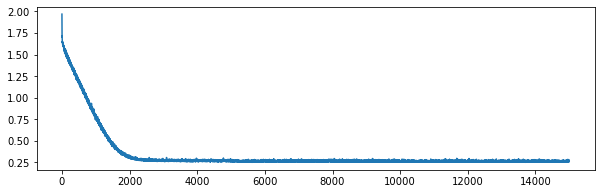

idx 295
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1190/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.002295875277962398 0.0099502941384079
std_all 0.03301875280922253 0.010233432168752252
mean_all 0.003886663408197125 0.011081120265323501
std_all 0.04154494836461034 0.016237168568641155
mean_all -0.00023502904924255775 0.010743842520048482
std_all 0.035860817994351805 0.013185293804469159
[0.2377539  0.35594475 0.45104355 0.50556432 0.55394785 0.59439669
 0.63365706 0.66235797 0.68907141 0.71460792 0.73686252 0.75772555
 0.77586104 0.79350972 0.80841755 0.82292035 0.83527198 0.84744336
 0.8589976  0.86868906]
(81, 81)
[0.29324693 0.45909884 0.55712339 0.65040757 0.71595563 0.77413989
 0.81868539 0.8591891  0.8824302  0.90143198 0.91562459 0.92868707
 0.93924879 0.94755343 0.9556641  0.96191207 0.96714958 0.97110877
 0.97478438 0.97753334]
(64, 81)
[0.25365314 0.38038638 0.46255307 0.51749077 0.56641249 0.60901673
 0.64854071 0.

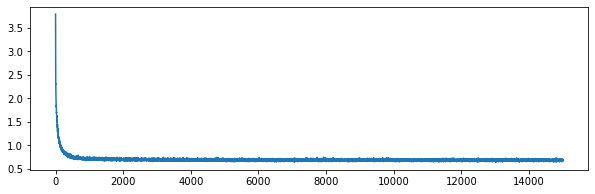

idx 300
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1191/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0010268941438522639 0.0052563219390306705
std_all 0.02165663693287397 0.02649524120414514
mean_all 5.464311666193144e-05 0.002261111773774188
std_all 0.02046736300299176 0.019806645815824492
mean_all 0.000702810468122153 0.0045092737212777765
std_all 0.0212602122895799 0.024476122693978336
[0.15638452 0.25103588 0.32777885 0.39183348 0.44633898 0.49504874
 0.53395766 0.5695713  0.60261725 0.63342908 0.66207147 0.68630359
 0.7080488  0.72882228 0.74701985 0.76428921 0.77986753 0.79470865
 0.80862294 0.82174456]
(81, 81)
[0.17027316 0.3091115  0.43128132 0.52828341 0.61972075 0.6801886
 0.72615282 0.76370195 0.79379261 0.82079847 0.84340488 0.85993478
 0.87550973 0.89050114 0.90467694 0.91630354 0.92579362 0.93422325
 0.94103472 0.94704144]
(64, 81)
[0.13497686 0.24723225 0.3310143  0.39739931 0.45934744 0.50638557
 0.55051938 0.5932399  0.6259

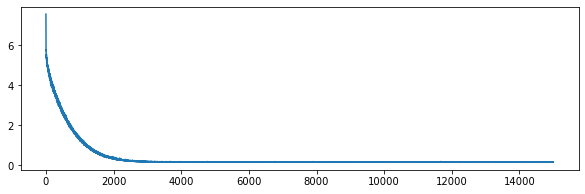

idx 305
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1254/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00044802127272388536 0.010083105853669515
std_all 0.02427659657459193 0.007777532871720422
mean_all 0.0017917628085766446 0.012006775166967389
std_all 0.030185568620625953 0.012785547573391644
mean_all 0.0002985734210429579 0.010814267104821583
std_all 0.02624625392326994 0.010127973840146113
[0.22145453 0.31639903 0.39500333 0.46620765 0.50887327 0.54929515
 0.58639861 0.62104893 0.64805994 0.67047555 0.69187268 0.71191423
 0.72979535 0.7464786  0.76291895 0.77652484 0.78889007 0.8011501
 0.81157143 0.82135524]
(81, 81)
[0.37784475 0.51314858 0.59888098 0.66508642 0.71057326 0.7487592
 0.78455939 0.81090132 0.83525159 0.85168015 0.86505466 0.87666508
 0.8868947  0.89573699 0.90394705 0.91096802 0.91711855 0.92296971
 0.92820243 0.9331193 ]
(81, 81)
[0.2677496  0.36843734 0.4438105  0.50927786 0.55446372 0.59077342
 0.62471724 0.65

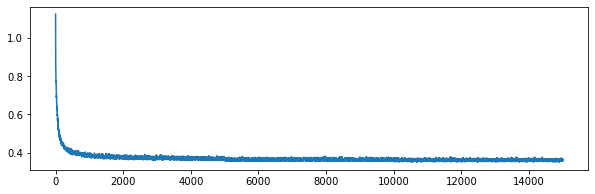

idx 310
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1254/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -7.525534705457771e-05 0.007476296080894491
std_all 0.02130721692419787 0.009080505485309368
mean_all 0.000676297236140709 0.006509009038293883
std_all 0.023641869885935654 0.02660676337742141
mean_all 0.0001752621806771845 0.007177134038718452
std_all 0.022085434578110463 0.017092539829418052
[0.22627579 0.33060837 0.41004559 0.4744901  0.51868342 0.55404216
 0.58699528 0.61781142 0.64434147 0.66703666 0.68683332 0.70511985
 0.72187546 0.73725481 0.75078716 0.76366596 0.77612943 0.78777747
 0.79863284 0.80835155]
(81, 81)
[0.28432511 0.39661351 0.48570842 0.54213277 0.59641879 0.64393734
 0.68036016 0.70834299 0.73451513 0.75573595 0.77323231 0.7900811
 0.80595004 0.81739447 0.82862753 0.83869028 0.84835233 0.8573832
 0.86578554 0.873403  ]
(81, 81)
[0.24087966 0.34118974 0.42014979 0.48249342 0.52487289 0.5642964
 0.59694487 0.62642679 0.65311

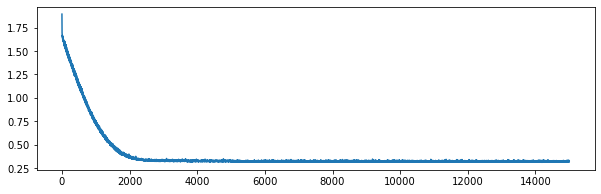

idx 315
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1255/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0010875564504264222 0.01186983519337186
std_all 0.031520941308303074 0.0108689253328846
mean_all 0.002329306629552496 0.014816387558100831
std_all 0.03935113732108446 0.018963534313275906
mean_all 5.1397909566550376e-05 0.01302682639162158
std_all 0.034131006645896876 0.014568886434607664
[0.20628313 0.31907188 0.39699445 0.46006181 0.51136129 0.55401965
 0.5889302  0.62074804 0.64778544 0.67174246 0.69444895 0.71393334
 0.73292214 0.74995255 0.76524857 0.77884637 0.79117446 0.80270805
 0.81348958 0.82342226]
(81, 81)
[0.30741616 0.43418247 0.51977606 0.5950989  0.66390979 0.71152431
 0.749176   0.78353345 0.81329491 0.83768531 0.85471671 0.86838344
 0.87912844 0.88918292 0.89763455 0.90470253 0.91108192 0.91729701
 0.9229535  0.92807758]
(81, 81)
[0.2335155  0.34489849 0.42110084 0.48290753 0.52945085 0.57070054
 0.60982378 0.64112

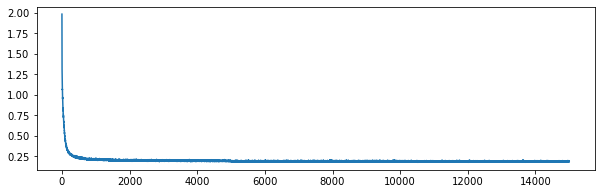

idx 320
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1318/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0007666634169432897 0.007655248597391154
std_all 0.021738230546568142 0.0076347676632384604
mean_all 0.0004125980371873718 0.007664305026542144
std_all 0.024524318127940013 0.024935583024351636
mean_all 0.0006486416236913171 0.007660087218339229
std_all 0.022666926407025435 0.015743120310313115
[0.21915759 0.30110873 0.3748906  0.42475688 0.46865935 0.50047488
 0.53067662 0.557749   0.58323915 0.60527514 0.62452549 0.64239229
 0.65876307 0.67426693 0.68955834 0.703224   0.71665178 0.72926358
 0.74073032 0.75146208]
(81, 81)
[0.26801439 0.3695878  0.45368977 0.52168143 0.57141993 0.61273985
 0.64647803 0.67447532 0.6986633  0.71850932 0.73663074 0.75244188
 0.76642777 0.7790945  0.79028298 0.8003616  0.80946747 0.81825862
 0.8267206  0.8344492 ]
(81, 81)
[0.2328698  0.31678494 0.39577297 0.44896151 0.49186131 0.52515625
 0.55592584 0.58123296 0.60

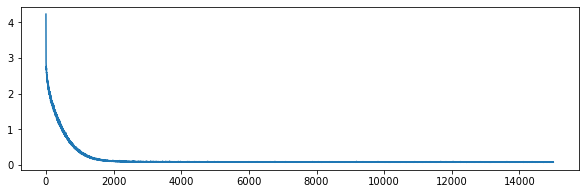

idx 325
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1318/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -1.9443835964270324e-05 0.009307926536277765
std_all 0.02317492139436211 0.00786335718834082
mean_all 0.0004958904995491721 0.012262946896505122
std_all 0.02916301137511631 0.01126229979241686
mean_all 0.0001523342758735439 0.010389608682304187
std_all 0.025170951387946842 0.009563977268355716
[0.19245165 0.2914837  0.36501148 0.42690841 0.47024299 0.51043991
 0.5415685  0.56975455 0.59482387 0.61686151 0.63750622 0.65711129
 0.67553058 0.69249229 0.70868978 0.72291114 0.73658514 0.74923318
 0.76119674 0.7725103 ]
(81, 81)
[0.38709032 0.51290025 0.5980162  0.66365265 0.71563817 0.7496159
 0.77938921 0.80495905 0.82755754 0.84176821 0.85366887 0.86427726
 0.87293468 0.88111278 0.8886249  0.89476244 0.90045011 0.90569798
 0.91053526 0.91488489]
(81, 81)
[0.25264752 0.35660972 0.42379236 0.48938139 0.53211805 0.5674766
 0.59756825 0.

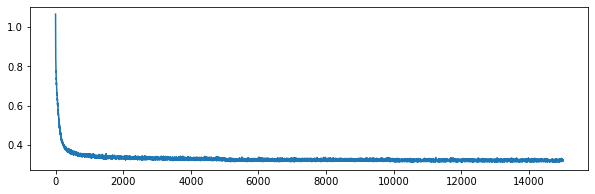

idx 330
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1319/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.00022527296674154526 0.00833576349459275
std_all 0.022956468220303547 0.01020715042708543
mean_all 0.0004116159920318175 0.008028647636823802
std_all 0.02722963729228639 0.027953363507494226
mean_all -1.2976647150424414e-05 0.008240135664654199
std_all 0.024380857910964494 0.018275080364707725
[0.17567559 0.26371073 0.3330981  0.38397722 0.43389323 0.47016694
 0.50269184 0.53116483 0.55684539 0.57755386 0.59730413 0.61644627
 0.63444997 0.65066476 0.66552337 0.67974569 0.69295011 0.70558866
 0.71781126 0.72967794]
(81, 81)
[0.25337219 0.3763413  0.45281899 0.51837301 0.5718639  0.61070624
 0.64421165 0.67312313 0.70008579 0.72325705 0.74187    0.75841301
 0.7720001  0.78476069 0.79552549 0.80518176 0.81428392 0.82289402
 0.83094956 0.83867344]
(81, 81)
[0.19927075 0.29006517 0.36485438 0.41788154 0.46546342 0.49827324
 0.52956737 0.55680211 0.582

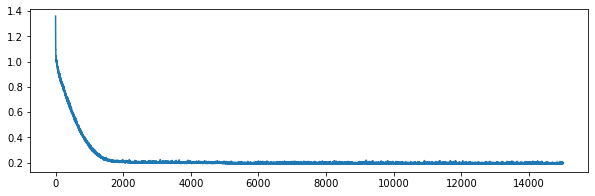

idx 335
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1319/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00047915299723275085 0.011332235677287729
std_all 0.028170055345653172 0.009732816597356548
mean_all 0.0007964926659647316 0.014888482778727053
std_all 0.03651835281161192 0.013879999571781662
mean_all -5.393777616692335e-05 0.012643719102766588
std_all 0.03095282116763942 0.011952301586839612
[0.17900881 0.28085442 0.35630308 0.4127763  0.46113096 0.50417635
 0.53655127 0.56610873 0.59122613 0.61550218 0.63724253 0.6580593
 0.67743529 0.6957129  0.71228735 0.72744313 0.7419906  0.75537039
 0.7678041  0.77975724]
(81, 81)
[0.35674859 0.51425063 0.59192328 0.64930494 0.69448233 0.73126884
 0.76448147 0.79004324 0.81480803 0.83541693 0.84824771 0.86074581
 0.8697263  0.87842846 0.88640517 0.89343547 0.89971245 0.90547467
 0.9111801  0.91617421]
(81, 81)
[0.23373363 0.34784403 0.4150208  0.47554868 0.518027   0.5566513
 0.58846893 

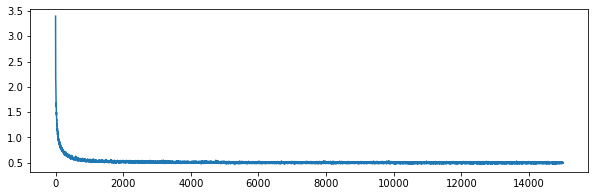

idx 340
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1382/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00013054487874858617 0.005477263900702405
std_all 0.018704187686551774 0.008221440400076904
mean_all 0.0001931477581502667 0.0031080673316066093
std_all 0.021163808085325912 0.023566642549679124
mean_all 0.00015141250521581303 0.004818835784733415
std_all 0.01952406115280982 0.01521626279755122
[0.17785663 0.2894029  0.38516302 0.45503341 0.51144809 0.56267935
 0.6100302  0.64179085 0.6708232  0.69575566 0.71808459 0.73831669
 0.75681389 0.77446516 0.78891077 0.80287902 0.81620433 0.82846577
 0.83962599 0.85003418]
(81, 81)
[0.19970779 0.36340058 0.46686381 0.55360284 0.62271521 0.67763672
 0.72321005 0.7625391  0.79369125 0.81940237 0.844252   0.86335989
 0.87748701 0.8904727  0.90209953 0.91334398 0.9231045  0.93250892
 0.93998011 0.94708982]
(64, 81)
[0.17526391 0.28626234 0.37656991 0.44347853 0.51010317 0.55996291
 0.60491041 0.64465881 

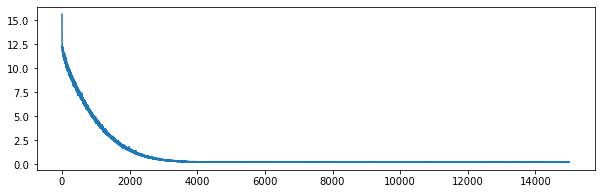

idx 345
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1383/actrelu/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0007732557575475824 0.00880897286184581
std_all 0.02570939598954467 0.01263671428724329
mean_all 0.001546450893813442 0.010137237695679216
std_all 0.031119132776953586 0.014260724412827925
mean_all -2.0207093907442103e-08 0.009337147193853949
std_all 0.02751264158534764 0.01344434856245256
[0.25172992 0.35176142 0.43007749 0.49016395 0.53984216 0.58418943
 0.61929989 0.65060644 0.67966513 0.70543526 0.7302134  0.75172881
 0.77164115 0.79048175 0.80697198 0.82134568 0.83386005 0.84592678
 0.8573826  0.86709357]
(81, 81)
[0.31881473 0.45151317 0.57119217 0.67467318 0.72692473 0.77764225
 0.81836503 0.85364497 0.87619829 0.89537952 0.91140963 0.92431487
 0.93388195 0.94251308 0.94860127 0.95464    0.95934372 0.96388968
 0.96786192 0.97132384]
(64, 81)
[0.26949532 0.37518856 0.45941611 0.53178227 0.57632268 0.61842687
 0.65350464 0.684

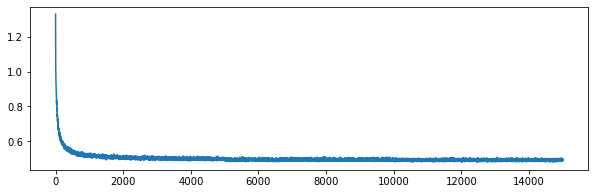

idx 350
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1383/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0005022824280496847 0.0043104375328630595
std_all 0.017367368502215604 0.009444930516467817
mean_all 0.0003140003158418679 0.0034123092583599984
std_all 0.021405514838996144 0.02358177844115083
mean_all -0.00023018818008583384 0.004051658491810015
std_all 0.01871341728114245 0.015762664572345614
[0.18150672 0.2885652  0.37062011 0.43563366 0.48869296 0.53931389
 0.58030942 0.6174525  0.64749572 0.67600931 0.70068774 0.72400785
 0.74401266 0.76351723 0.78157047 0.79768585 0.81309992 0.82595046
 0.83740619 0.84876738]
(81, 81)
[0.24152943 0.39365365 0.49811783 0.58079864 0.63438055 0.67902501
 0.72106296 0.75814797 0.78905538 0.81378812 0.83633844 0.85584731
 0.8734729  0.88590978 0.89784077 0.90783333 0.91665337 0.92449169
 0.93193679 0.9387103 ]
(64, 81)
[0.18964329 0.28353526 0.3757263  0.44574047 0.500875   0.54672455
 0.58788414 0.62406726

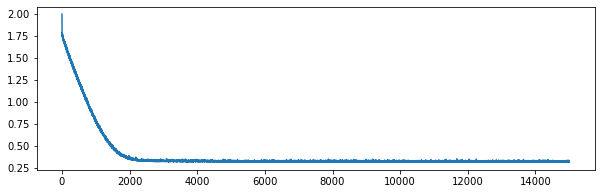

idx 355
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1446/actrelu/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0011196905121948827 0.011971952092895739
std_all 0.03164471933052607 0.010125958208952719
mean_all 0.0013465688331303065 0.0155676511102204
std_all 0.03802790236229456 0.016722264178448198
mean_all -0.0002976040637531531 0.013329941131290329
std_all 0.03377244700778223 0.013062255151952095
[0.22316422 0.31175206 0.39669011 0.4647697  0.51368189 0.56013281
 0.59340882 0.62158405 0.64733982 0.67077903 0.69350135 0.71283732
 0.73098683 0.74867459 0.76419483 0.77867094 0.79216752 0.80477205
 0.81643571 0.82736911]
(81, 81)
[0.33417559 0.48057177 0.56377631 0.63935401 0.69536983 0.73857658
 0.7727105  0.80393425 0.83331363 0.86047463 0.8733666  0.8852086
 0.89618828 0.90552772 0.9146795  0.92262485 0.92969619 0.93617997
 0.94137497 0.94603976]
(81, 81)
[0.25428578 0.35718107 0.43153185 0.49678071 0.54538504 0.59223612
 0.6250197  0.65348

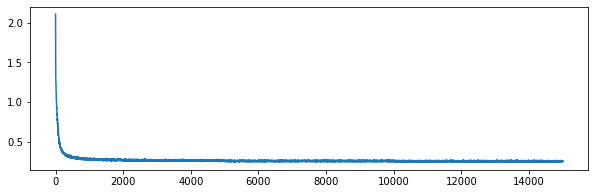

idx 360
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1447/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0007011803431329975 0.007170169298892862
std_all 0.01946666205010111 0.0050733264222938505
mean_all 0.0005072140276023455 0.006554627733686959
std_all 0.024087911110538054 0.02645588859695404
mean_all -0.00029838221955454986 0.006994266181355023
std_all 0.021007078403580088 0.015975279013537607
[0.22173249 0.31896009 0.41045599 0.46888061 0.51861732 0.55822608
 0.59283978 0.62076624 0.64498403 0.66832761 0.68951104 0.70796873
 0.72458408 0.73968208 0.75428719 0.76728727 0.77971763 0.79084491
 0.80126278 0.8115177 ]
(81, 81)
[0.28818407 0.38778096 0.48388817 0.54611262 0.59816503 0.64512095
 0.68276658 0.71740106 0.74752931 0.77000635 0.78772921 0.8026497
 0.8159285  0.82784328 0.83923736 0.84969113 0.85953127 0.86835058
 0.87655025 0.88383944]
(81, 81)
[0.23954014 0.3321935  0.42155442 0.47834237 0.52505209 0.56205385
 0.59367422 0.6248247  0.65

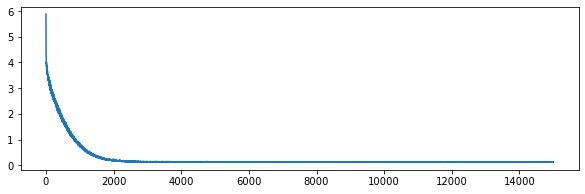

idx 365
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1447/actsoftplus/lossmse/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.0007487864132764945 0.010187917022095112
std_all 0.024310203299199088 0.0072325096478154565
mean_all 0.001135282705874883 0.011750461529237675
std_all 0.02958560359149954 0.011792465234143998
mean_all -0.0001207633735593687 0.010770749436611155
std_all 0.02606867006329924 0.009349400338571654
[0.2697965  0.38022922 0.44055191 0.4930885  0.53756259 0.57768726
 0.61316638 0.64241372 0.66771425 0.69113896 0.71036095 0.7293072
 0.74580017 0.76074543 0.77471342 0.78782731 0.80036481 0.81207484
 0.82328722 0.83279705]
(81, 81)
[0.38695411 0.50313498 0.57864691 0.64708682 0.70370952 0.75107902
 0.79132997 0.8216539  0.84919484 0.86925161 0.88071357 0.89169373
 0.90129941 0.90941788 0.91632575 0.92265806 0.92865246 0.93446916
 0.93960869 0.94376615]
(81, 81)
[0.30146498 0.40687868 0.46916889 0.52232911 0.56779351 0.60484479
 0.63968606

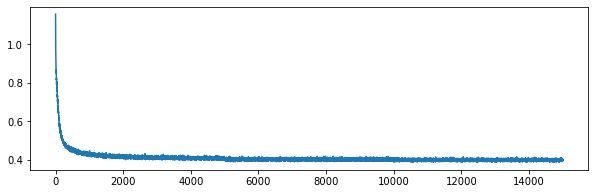

idx 370
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1510/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0001634056263049147 0.007752842017774008
std_all 0.022221688176892625 0.009404037531791419
mean_all 0.00038414571193853933 0.006726550852335408
std_all 0.02428817613568761 0.02853916208837241
mean_all 1.9111486442903252e-05 0.007431004419611418
std_all 0.02291051749649095 0.018204418250288453
[0.19790377 0.28840089 0.35740415 0.41570159 0.45851761 0.49747794
 0.52886222 0.55717985 0.58240405 0.60537394 0.62583597 0.64501044
 0.66329971 0.67970276 0.69488473 0.7097126  0.72260417 0.73497135
 0.74544161 0.75579346]
(81, 81)
[0.24914558 0.36688951 0.44945352 0.52580884 0.58218149 0.62160631
 0.65708565 0.69214086 0.72232111 0.74929215 0.76804362 0.78349047
 0.79757958 0.81026922 0.82022124 0.83008049 0.83912489 0.8475613
 0.85525826 0.86235638]
(81, 81)
[0.21181715 0.29759233 0.3778059  0.44123861 0.4835162  0.51689581
 0.54869088 0.57866164 0.60411

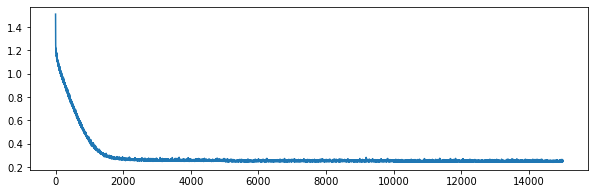

idx 375
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1510/actsoftplus/lossl1/k9/bn_preTrue/bn_b4_actTrue/model_seed0
mean_all -0.00017132223810405469 0.011308063302884919
std_all 0.02814338896450789 0.009138102600223446
mean_all 0.000951703383290289 0.014712286708038914
std_all 0.03658430797179876 0.014220499078968689
mean_all 0.00020301963569405984 0.012557026751776815
std_all 0.030957028633604847 0.011786034694282136
[0.1878849  0.28098506 0.36140436 0.42276959 0.4677825  0.51040413
 0.55054853 0.57951141 0.60683613 0.63360491 0.65646449 0.67794771
 0.69749231 0.71618539 0.73074932 0.74492515 0.75861145 0.77091844
 0.78281701 0.79426797]
(81, 81)
[0.33863744 0.47844898 0.57702427 0.63706686 0.6909439  0.73201783
 0.76756634 0.79966935 0.83033483 0.8549335  0.86805805 0.87961624
 0.88929234 0.89752517 0.90442658 0.91114069 0.9170557  0.92251862
 0.92715762 0.93161396]
(81, 81)
[0.23288352 0.33285348 0.4074869  0.47395327 0.51696    0.55849135
 0.59680043

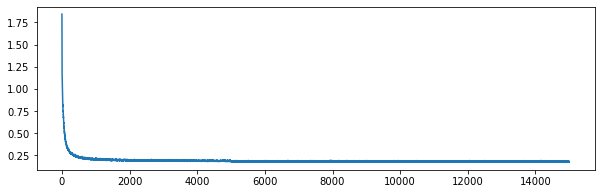

idx 380
key yuanyuan_8k_a_3day/feature_approximation_kbl_recurrent_k3_sep2+1/baseidx1511/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0002326838173082347 0.007552789510892198
std_all 0.01994926334552706 0.00742000840773155
mean_all 0.00045872214857700877 0.007616424181913634
std_all 0.02226617213260014 0.023706235025428887
mean_all -2.215162013153549e-06 0.007581070085350008
std_all 0.020721566274551424 0.015007524107455374
[0.21767127 0.31904527 0.39364012 0.44728224 0.49187532 0.52489188
 0.55433587 0.58075441 0.60598585 0.62683686 0.64571787 0.6638585
 0.68014279 0.69496014 0.70822118 0.72084038 0.732255   0.74320908
 0.75291502 0.7624277 ]
(81, 81)
[0.27414631 0.38056392 0.45428744 0.52506613 0.58111241 0.6164255
 0.6461375  0.67383027 0.69760036 0.71721347 0.73483898 0.74889677
 0.7622669  0.77338356 0.78429155 0.79401093 0.8032964  0.81219681
 0.82055491 0.82795277]
(81, 81)
[0.23090525 0.32451529 0.40506739 0.46138344 0.50675265 0.53526569
 0.56272531 0.58802857 0.6

In [10]:
collect_all()

In [11]:
# note that based on the loss curves, the approximation is not very successful.
# compared to local PCN-maskcnn or local PCN-imagenet

# check `/scripts/debug/feature_approximation`. The input distribution (mean and std) differences among these three
# settings cannot justify having 0.2~0.5 loss here while having 0.02 loss there 